In [1]:
source("/secure/projects/HTAPP_MBC/src/init.R")
library(igraph)
library(scales)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: cowplot

Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Loading required package: Matrix
Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading combined annotation: annot
Warning message in fread(combined_annot_file):
"Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning."
Attaching package: 'igraph'

The following object is masked from 'package:gtools':

    permute

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [2]:
wd=file.path(analysisDir,"00_spatial_probes")
dir.create(wd)
setwd(wd)

Warning message in dir.create(wd):
"'/scratch/projects/HTAPP_MBC//analysis//00_spatial_probes' already exists"

In [3]:
#metastasis bulk mean expression
mets_bulk=unique(fread(file.path(extDir,"bulk/TPM.Mets.AllBulkGenes.tsv")))

In [4]:
simpleCache(cacheName = "fresh_combined",
            instruction = "", 
            cacheDir = cacheDir, 
            cacheSubDir = "combined_seurat", 
            recreate = FALSE,assignToVariable = "cs")

Character instruction; consider wrapping in braces.
::Loading cache::	/scratch/projects/HTAPP_MBC//RCache//combined_seurat/fresh_combined.RData


In [5]:
#discriminate between b-cells and plasma cells and rename ipsCells to Epithelial_stem
lab_dt=as.data.table(cs@meta.data[,c("labels","labels_detail")],keep.rownames = "cellid")
lab_dt[,labels_mod:=ifelse(labels=="B_cell"&labels_detail=="B_cell:Plasma_cell","Plasma_cell",labels),]
lab_dt[,labels_mod:=ifelse(labels%in%c("iPS_cells"),"Epithelial_stem",labels_mod),]
setnames(lab_dt,c("labels","labels_mod"),c("labels_orig","labels"))
lab_df=data.frame(lab_dt,row.names = "cellid")
cs=AddMetaData(cs,metadata = lab_df)

In [6]:
md=as.data.table(cs@meta.data,keep.rownames = "cellid")

In [7]:
cell_types=c("Epithelial_cells","Epithelial_stem","Fibroblasts","Endothelial_cells","Macrophage","Monocyte","NK_cell","T_cells","B_cell","Plasma_cell")

In [8]:
#function to order genes according to their expression pattern
order_genes=function(obj,sname="labels",svals,ncells=500,genes){
    dat=SubsetData(obj,subset.name = sname,accept.value = svals,max.cells.per.ident = ncells)@scale.data[genes,]
    cl=hclust(dist(dat))
    genes_ordered=data.table(gene=cl$labels[cl$order],order=1:length(cl$order))
    return(genes_ordered[order(order)])  
}

### Load all the data

In [12]:
#preselected interest
int=fread("pre_interest.tsv")
int_order=order_genes(cs,svals = cell_types,genes = unique(int$gene))
head(int)

gene  type       priority assay       
1 ESR1  Receptors  1        interest_mbc
2 PGR   Receptors  1        interest_mbc
3 ERBB2 Receptors  1        interest_mbc
4 AKT1  Resistance 0        interest_mbc
5 AR    Resistance 1        interest_mbc
6 ARAF  Resistance 0        interest_mbc

In [13]:
#preselected codex mibi
cm=fread("pre_codex_mibi.tsv")
cm=cm[assay!="codex_fixed"]
cm_order=order_genes(cs,svals = cell_types,genes = unique(cm$gene))
head(cm)

gene  type      priority assay       
1 KIT   malignant 1        codex_frozen
2 KIT   malignant 1        mibi_fixed  
3 ITGAM immune    1        mibi_fixed  
4 ITGAX immune    1        codex_frozen
5 ITGAX immune    1        mibi_fixed  
6 IL3RA immune    1        codex_frozen

In [14]:
#data pam50
p50_fresh=fread("data_pam50.tsv")
head(p50_fresh)

gene  type   priority  assay      
1 EXO1  Basal+ 0.2485924 pam50_fresh
2 MELK  Basal+ 0.6671192 pam50_fresh
3 MYBL2 Basal+ 0.8575626 pam50_fresh
4 CCNE1 Basal+ 0.2283927 pam50_fresh
5 CENPF Basal+ 0.2727901 pam50_fresh
6 FOXC1 Basal+ 1.0000000 pam50_fresh

In [15]:
#data pam50
p50_frozen_v2=fread("data_frozen_pam50.tsv")
p50_frozen_v2[,assay:=paste0(assay,"_v2"),]
p50_frozen=fread("data_frozen_V3_pam50.tsv")
head(p50_frozen)

gene  type   priority  assay       
1 KIF2C Basal+ 0.1496610 pam50_frozen
2 KRT5  Basal+ 0.9000000 pam50_frozen
3 CDC20 Basal+ 0.4731347 pam50_frozen
4 FOXC1 Basal+ 1.0000000 pam50_frozen
5 CEP55 Basal+ 1.0000000 pam50_frozen
6 CCNE1 Basal+ 1.0000000 pam50_frozen

In [16]:
#data ct
ct_fresh=fread("data_ct.tsv")
head(ct_fresh)

gene    type               priority  assay        
1 TCL1A   B_cell+            0.9000000 data_ct_fresh
2 MS4A1   B_cell+            1.0000000 data_ct_fresh
3 HSPG2   Endothelial_cells+ 0.1971411 data_ct_fresh
4 FAM167B Endothelial_cells+ 0.2143938 data_ct_fresh
5 PLVAP   Endothelial_cells+ 1.0000000 data_ct_fresh
6 GNG11   Endothelial_cells+ 1.0000000 data_ct_fresh

In [17]:
#data ct
ct_frozen_v2=fread("data_frozen_ct.tsv")
ct_frozen_v2[,assay:=paste0(assay,"_v2"),]
ct_frozen=fread("data_frozen_V3_ct.tsv")
head(ct_frozen)

gene     type    priority assay         
1 TENT5C   B_cell+ 0.641614 data_ct_frozen
2 MZB1     B_cell+ 0.900000 data_ct_frozen
3 POU2AF1  B_cell+ 1.000000 data_ct_frozen
4 BANK1    B_cell+ 1.000000 data_ct_frozen
5 IFNG-AS1 B_cell+ 1.000000 data_ct_frozen
6 FCRL5    B_cell+ 1.000000 data_ct_frozen

In [18]:
#topics
topics_fresh=fread("topics_fresh.tsv")
head(topics_fresh)

gene     type                    priority assay       
1 CD74     malignant_t3_GO:0019886 1        topics_fresh
2 HLA-DRA  malignant_t3_GO:0019886 0        topics_fresh
3 HLA-DRB1 malignant_t3_GO:0019886 0        topics_fresh
4 FASN     malignant_t6_GO:0071616 1        topics_fresh
5 SCD      malignant_t6_GO:0071616 0        topics_fresh
6 SLPI     malignant_t7_GO:0043312 1        topics_fresh

### Plot expression for selected genes

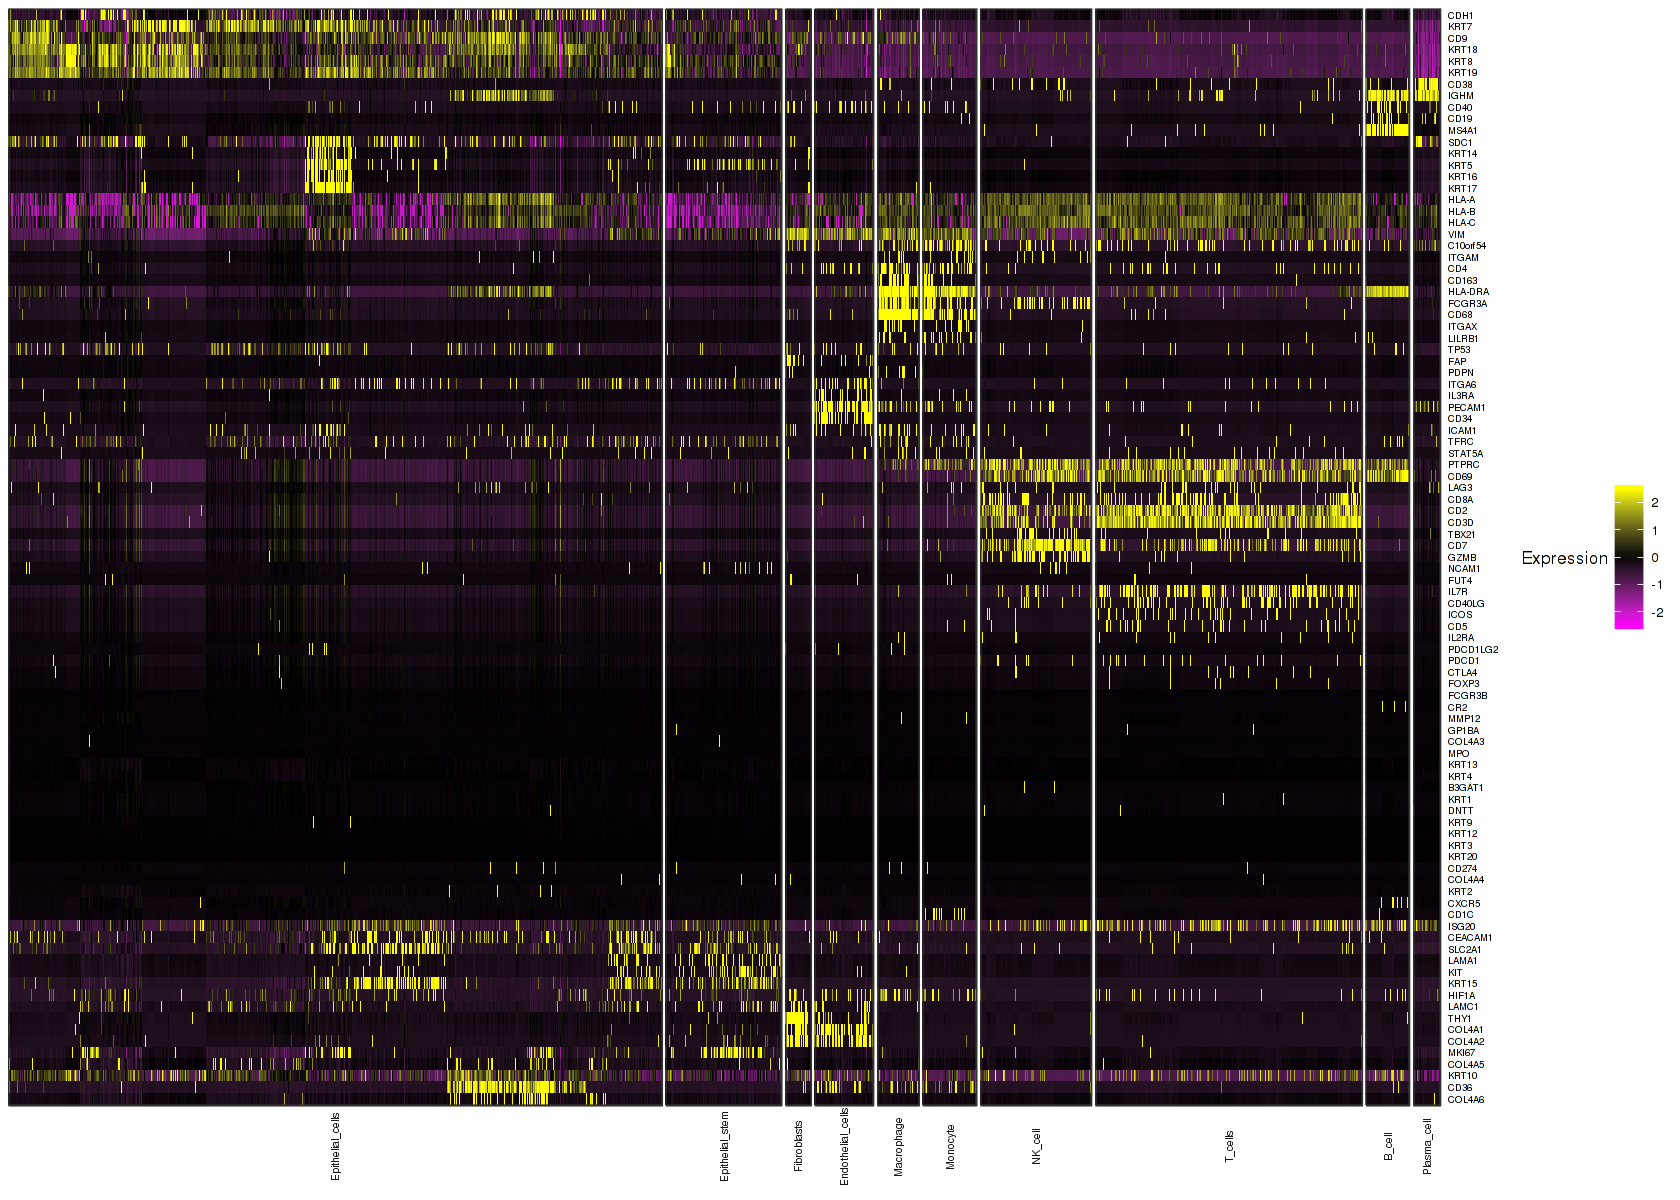

In [197]:
#codex mibi genes
#options(repr.plot.width = 14, repr.plot.height = 6.5)
options(repr.plot.width = 14, repr.plot.height = 10)
DoHeatmap(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident = Inf),group.cex = 6,group.order = cell_types,slim.col.label = TRUE,group.label.rot = TRUE,
          draw.line = TRUE,genes.use = cm_order$gene,group.by = "labels",cex.row = 5.5,cex.col = 0)

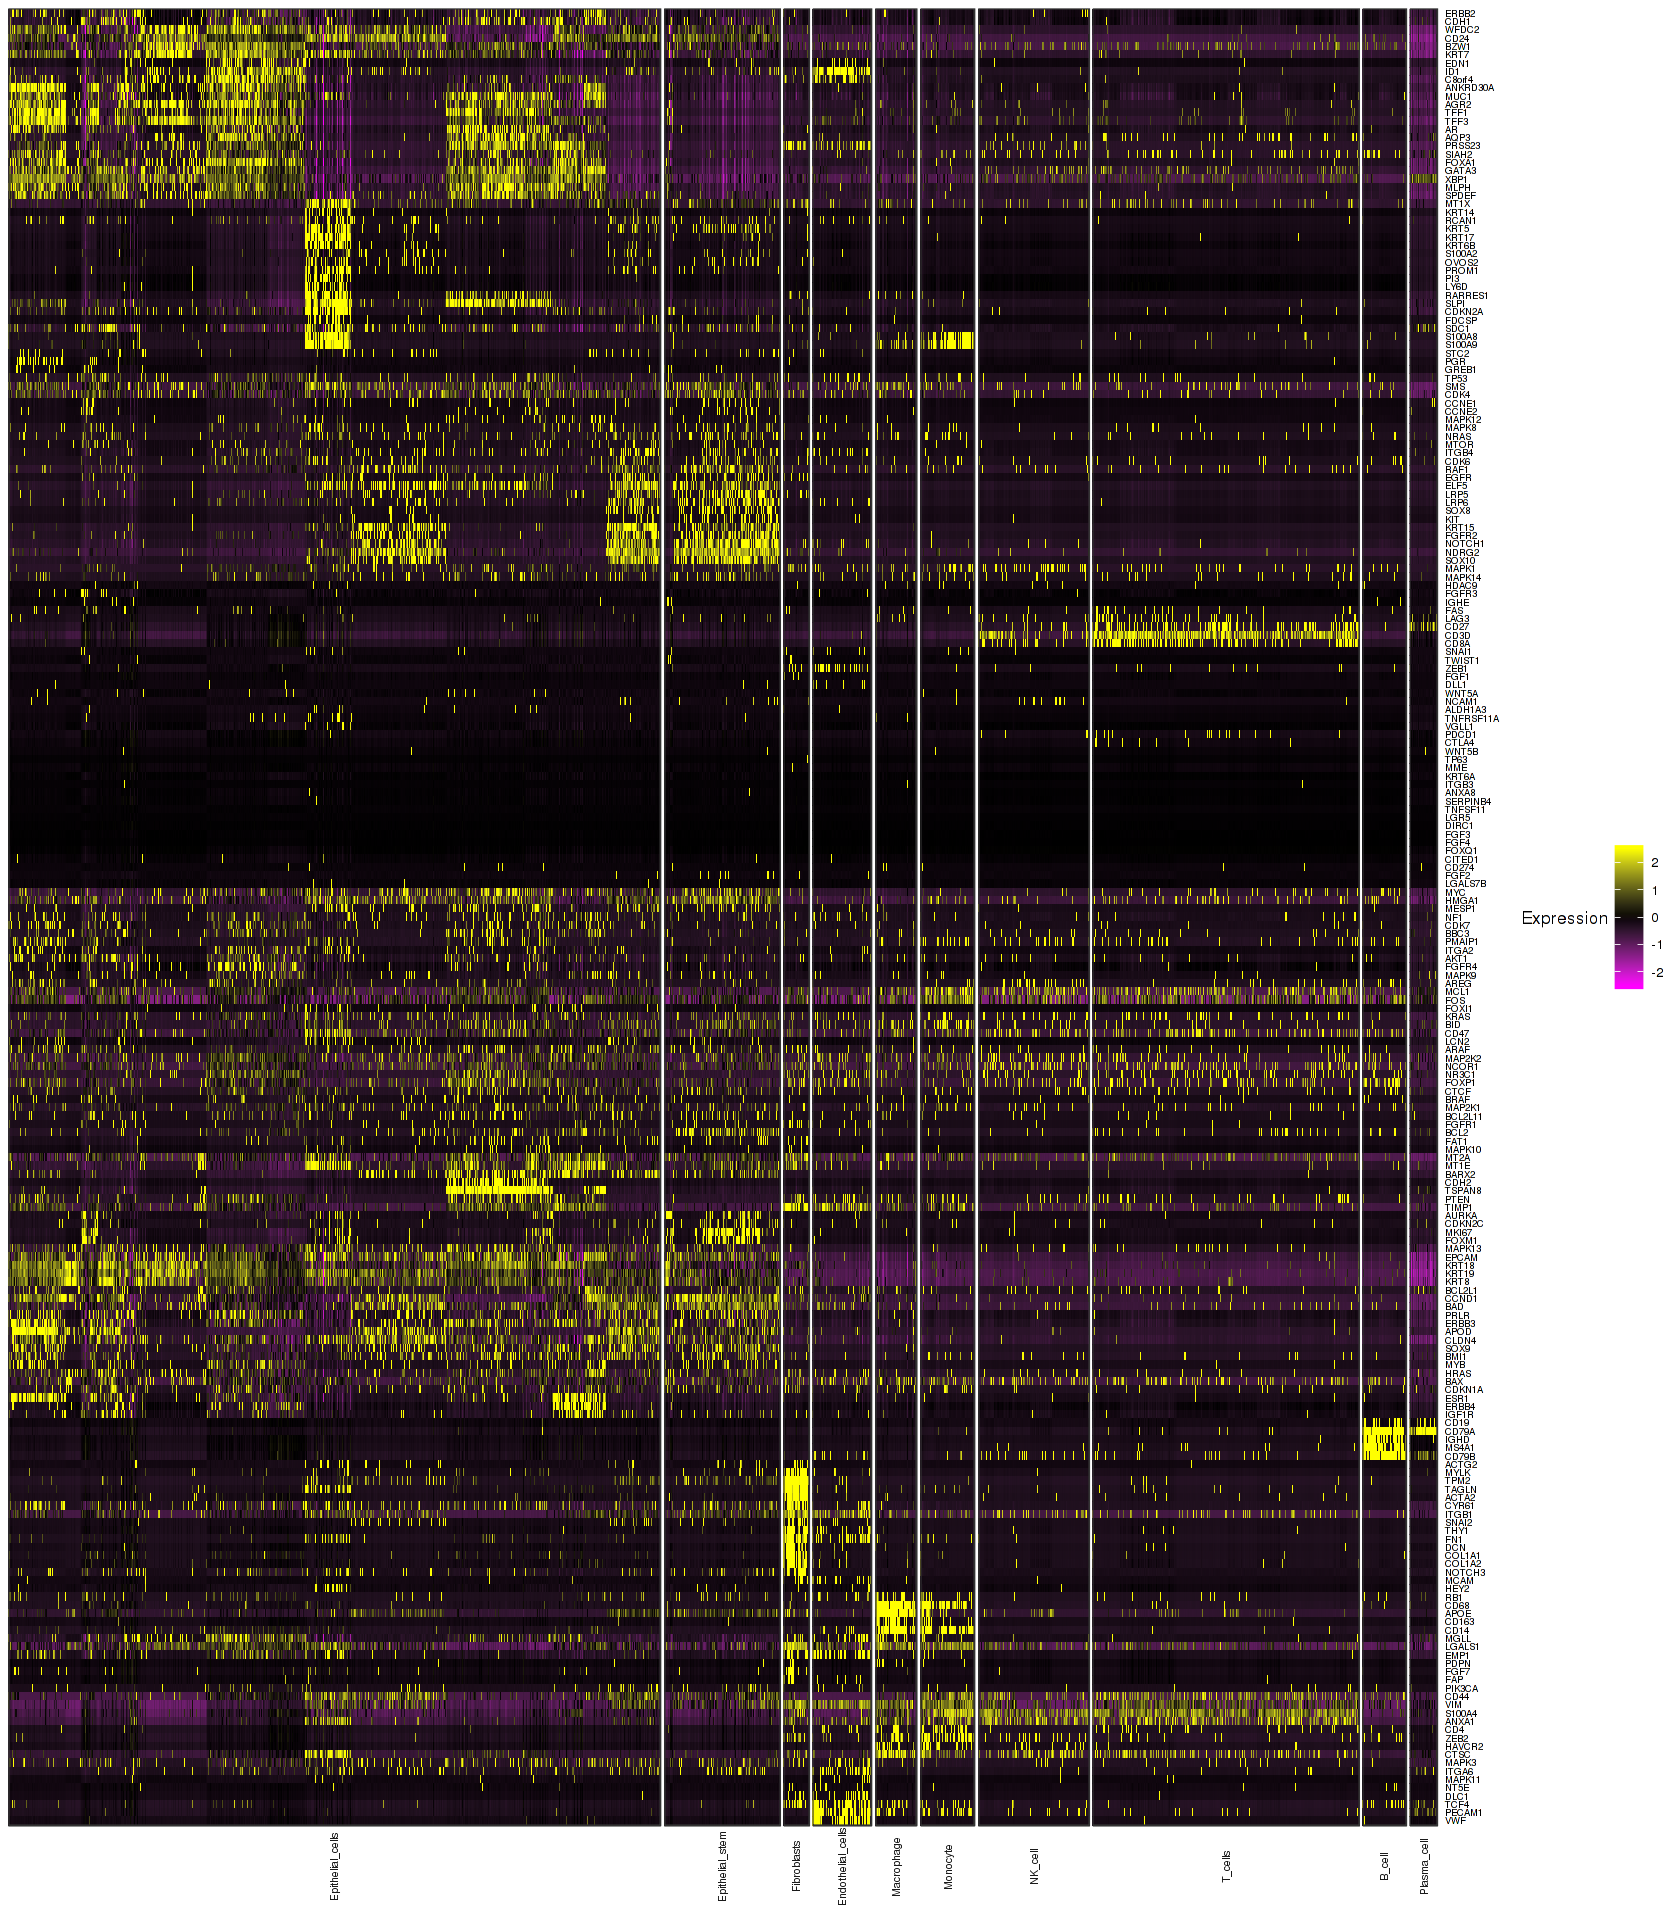

In [16]:
# interest genes
options(repr.plot.width = 14, repr.plot.height = 16)
DoHeatmap(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident = Inf),group.cex = 6,group.order = cell_types,slim.col.label = TRUE,group.label.rot = TRUE,
          draw.line = TRUE,genes.use = int_order$gene,group.by = "labels",cex.row = 5.5,cex.col = 0)

### Combine genes

In [19]:
combined=rbindlist(list(int,cm,p50_fresh,p50_frozen,ct_fresh,ct_frozen,topics_fresh),use.names = TRUE,fill=TRUE)
combined[,method:=assay,]
combined[,assay:=paste0(method,".",type),]
#make sure here that all genes are in the data
cat(combined[!gene%in%rownames(cs@data)]$gene)
combined=combined[gene%in%rownames(cs@data)]
head(combined)

TENT5C LINC02147 AC079950.1 AC004704.1 AC016205.1 AC020909.2

gene  type       priority assay                   method      
1 ESR1  Receptors  1        interest_mbc.Receptors  interest_mbc
2 PGR   Receptors  1        interest_mbc.Receptors  interest_mbc
3 ERBB2 Receptors  1        interest_mbc.Receptors  interest_mbc
4 AKT1  Resistance 0        interest_mbc.Resistance interest_mbc
5 AR    Resistance 1        interest_mbc.Resistance interest_mbc
6 ARAF  Resistance 0        interest_mbc.Resistance interest_mbc

In [199]:
#to compare V3 and V2 selections in frozen
comp_v3_v2=rbindlist(list(p50_frozen,ct_frozen,p50_frozen_v2,ct_frozen_v2),use.names = TRUE,fill=TRUE)
comp_v3_v2[,method:=assay,]
comp_v3_v2[,assay:=paste0(method,".",type),]

In [20]:
combined[,method:=factor(method,levels=c("pam50_frozen","pam50_fresh","interest_mbc","interest_ct","topics_fresh","data_ct_frozen","data_ct_fresh","mibi_fixed","codex_frozen","codex_fixed")),]

[1] 510

[1] 9

[1] 83

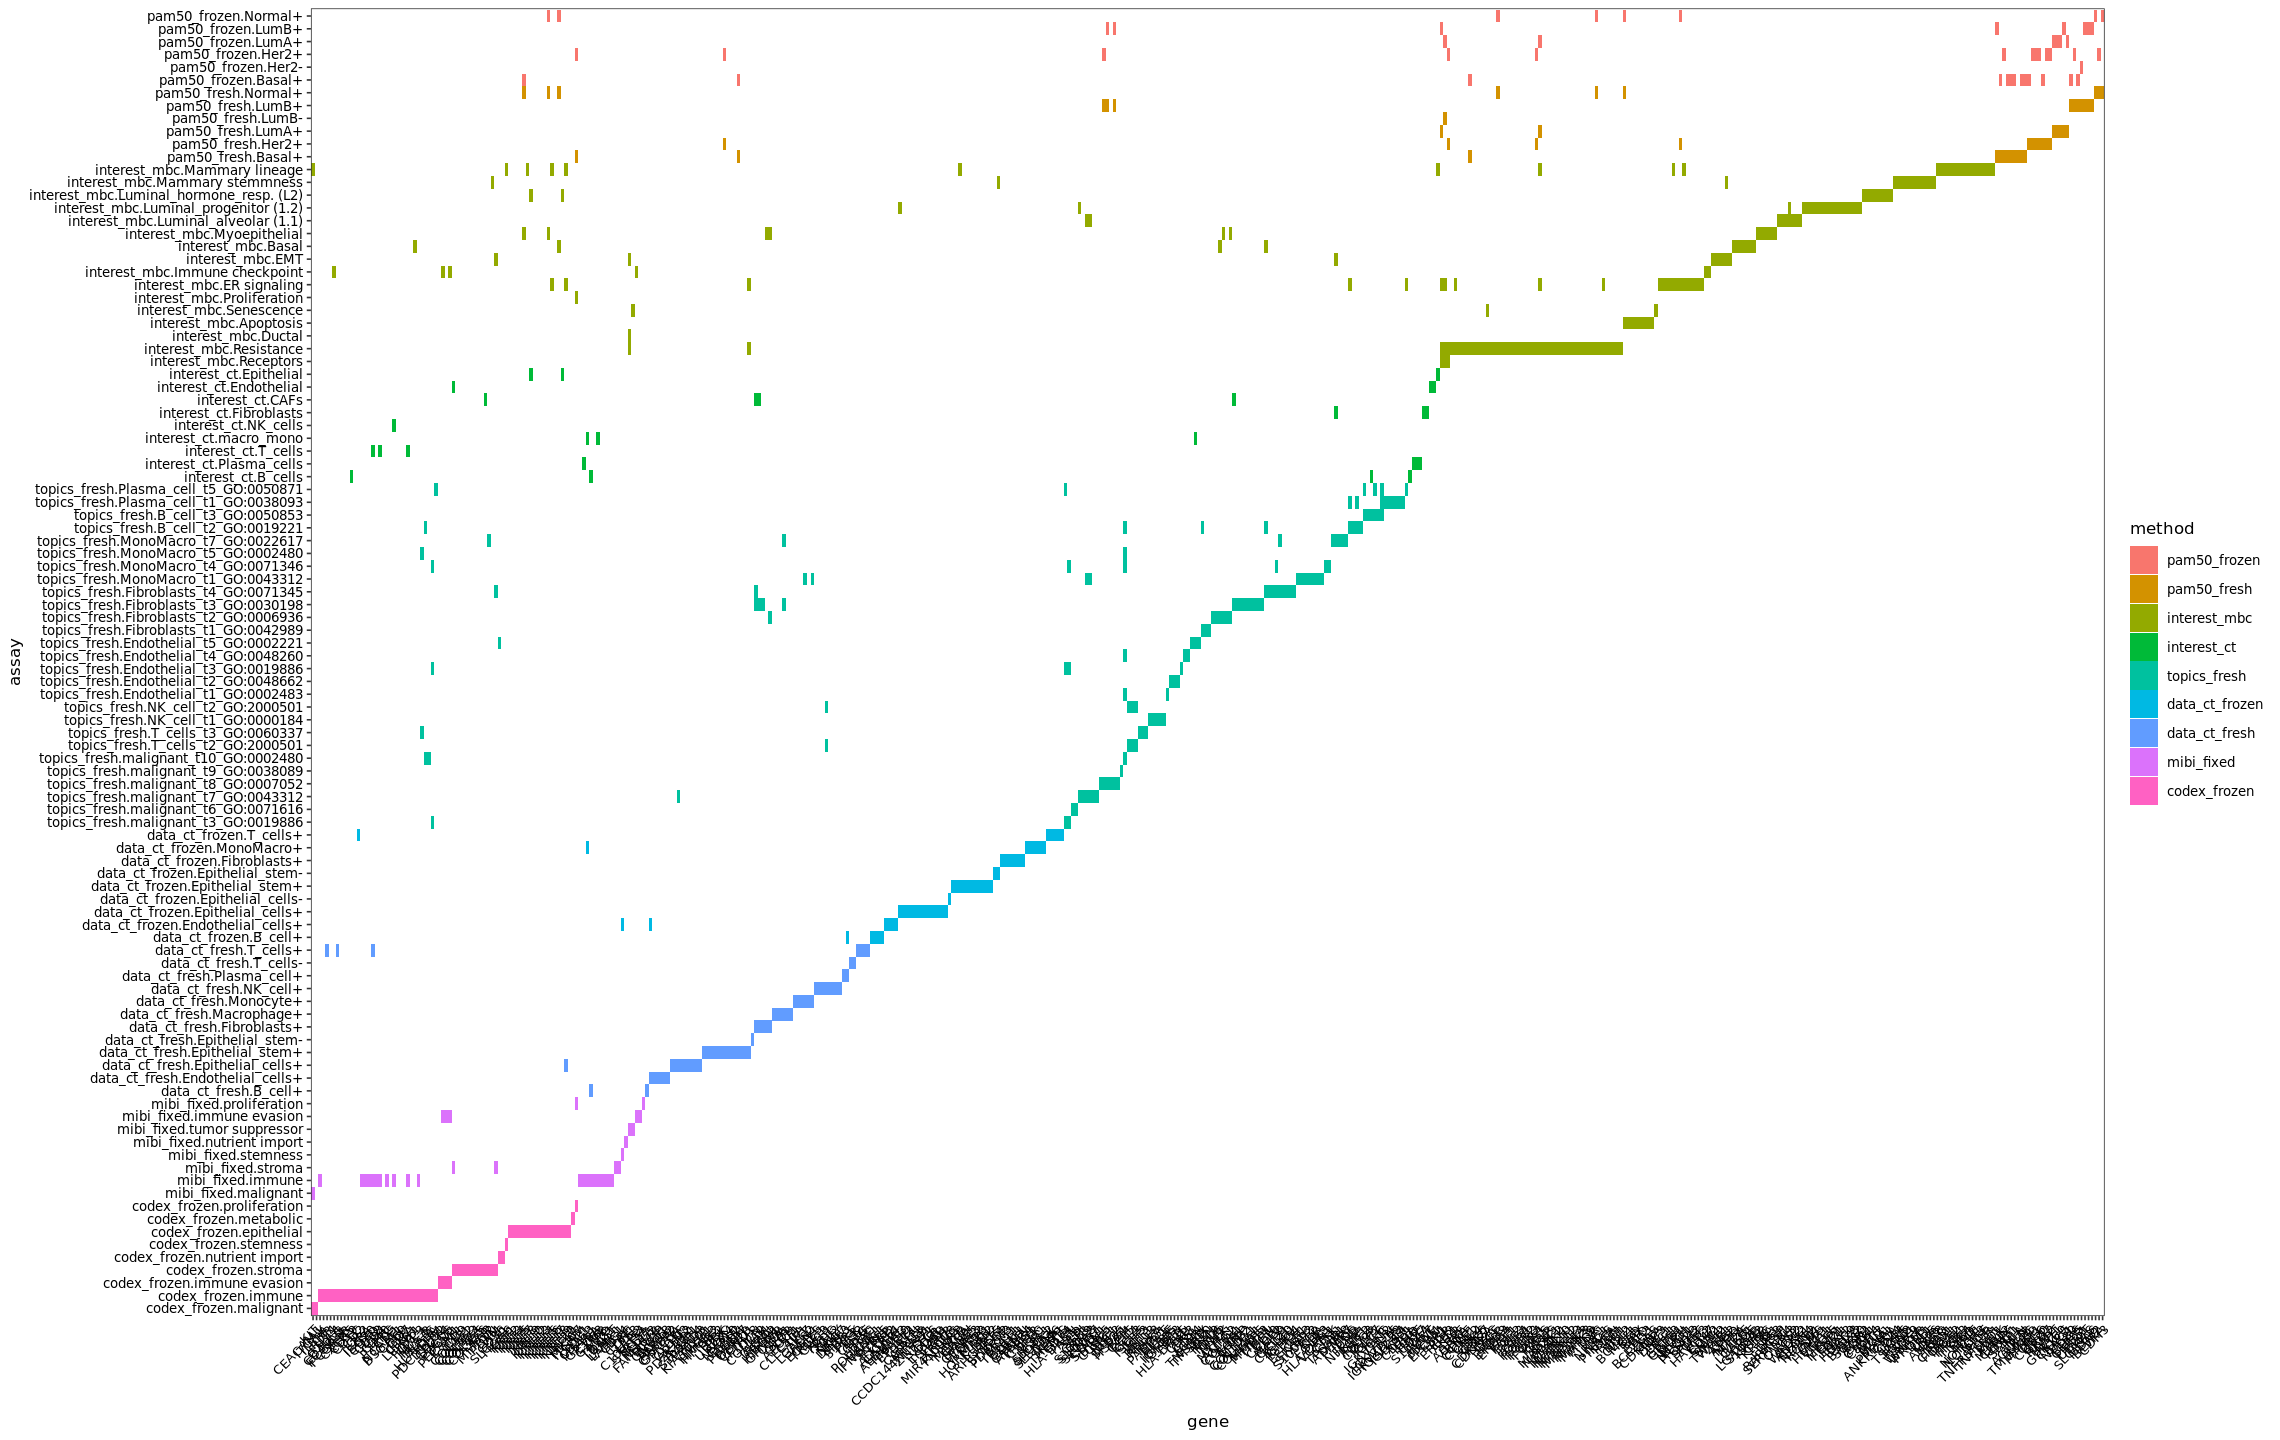

In [23]:
#all
options(repr.plot.width = 19, repr.plot.height = 12)
sub=copy(combined)
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))
length(unique(sub$method))
length(unique(sub$type))

[1] 277

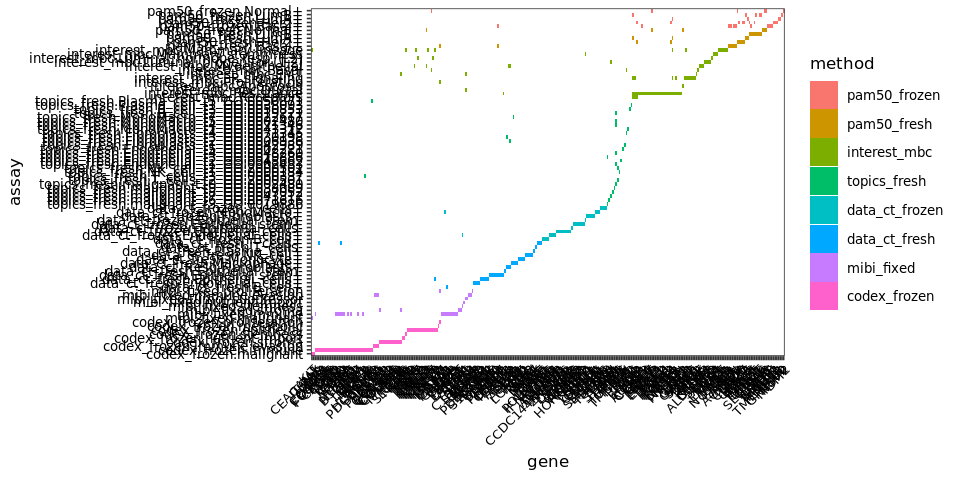

In [24]:
#priority==1
options(repr.plot.width = 8, repr.plot.height = 4)
sub=combined[priority==1]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))

[1] 44

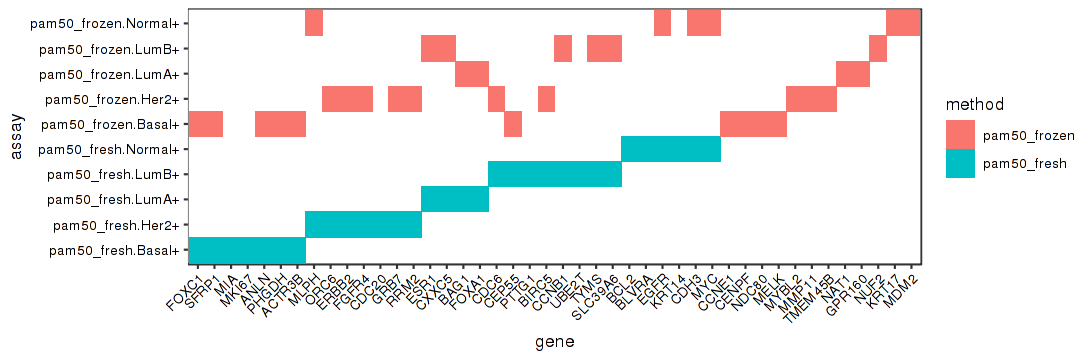

In [203]:
#priority==1 pam50
options(repr.plot.width = 9, repr.plot.height = 3)
sub=combined[priority==1&grepl("pam50",method)]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))

[1] 42

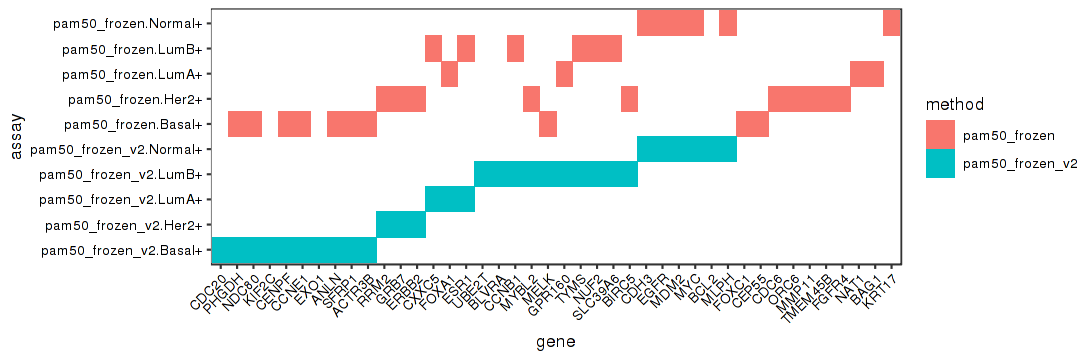

In [204]:
#priority==1 pam50
options(repr.plot.width = 9, repr.plot.height = 3)
sub=comp_v3_v2[priority==1&grepl("pam50",method)]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))

[1] 84

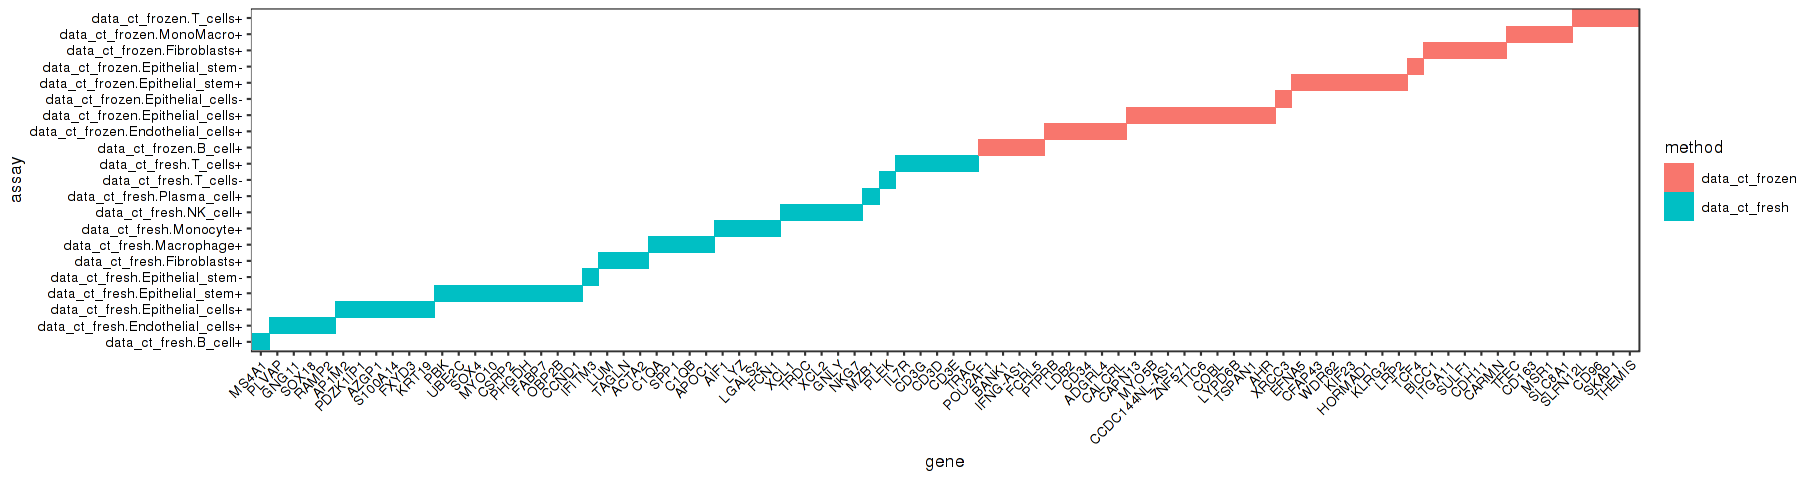

In [205]:
#priority==1 cell types
options(repr.plot.width = 15, repr.plot.height = 4)
sub=combined[priority==1&grepl("data_ct",method)]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))

[1] 68

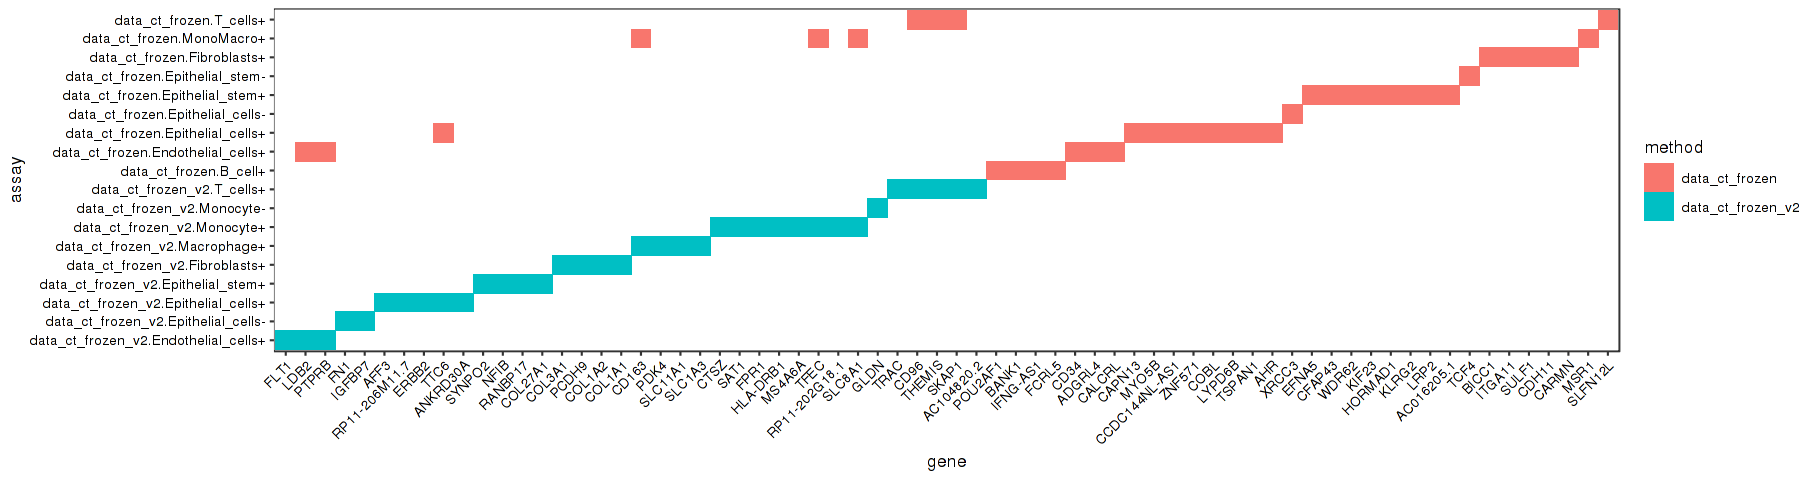

In [206]:
#priority==1 cell types compare V3 V2
options(repr.plot.width = 15, repr.plot.height = 4)
sub=comp_v3_v2[priority==1&grepl("data_ct",method)]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
length(unique(sub$gene))

#### Add gene-wise stats (across entire data set not per cell type)

In [25]:
combined[,variability:=sum(abs(cs@scale.data[unique(gene),])>1)/length(cs@scale.data[unique(gene),]),by="gene"] #recalculate variability such that it is for sure the same

In [26]:
combined[,N_expr_all:=apply(cs@raw.data[gene,],1,function(x)sum(x>=1)),]

In [27]:
combined[,perc_expr_all:=apply(cs@raw.data[gene,],1,function(x)sum(x>=1)/length(x)),]

In [28]:
cor=cor(t(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident =Inf)@scale.data[unique(combined$gene),]))

In [29]:
hcl=hclust(as.dist(-cor+1))
hcl_order=data.table(gene=hcl$label[hcl$order],cluster_order=1:length(hcl$label))

In [30]:
cor_dt=melt(as.data.table(cor,keep.rownames = "gene.1"),id.vars = "gene.1",value.name = "cor",variable.name = "gene.2")

In [31]:
cor_dt[,gene.2:=as.character(gene.2),]
cor_dt[,combi:=paste(sort(c(gene.1,gene.2)),collapse = "_"),by=1:nrow(cor_dt)]
head(cor_dt)

gene.1 gene.2 cor        combi     
1 ESR1   ESR1   1.00000000 ESR1_ESR1 
2 PGR    ESR1   0.24356314 ESR1_PGR  
3 ERBB2  ESR1   0.13502767 ERBB2_ESR1
4 AKT1   ESR1   0.04731234 AKT1_ESR1 
5 AR     ESR1   0.19908473 AR_ESR1   
6 ARAF   ESR1   0.02471454 ARAF_ESR1

In [32]:
cor_dt_red=cor_dt[!duplicated(combi)]

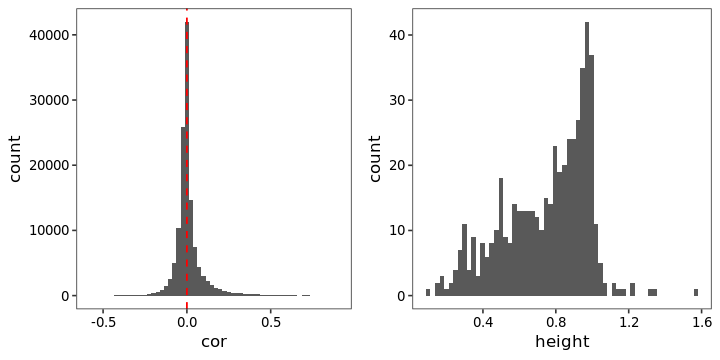

In [33]:
options(repr.plot.width = 6, repr.plot.height = 3)
p1=ggplot(cor_dt_red[gene.1!=gene.2],aes(x=cor))+geom_histogram(bins = 60)+geom_vline(xintercept = 0,lty=2,col="red")
p2=ggplot(data.table(height=hcl$height),aes(x=height))+geom_histogram(bins = 60)
plot_grid(p1,p2)

In [34]:
cl_0.7=clusters(graph_from_edgelist(as.matrix(cor_dt_red[cor!=1&cor>0.7,c("gene.1","gene.2")])))
cl_0.7$no
cl_0.6=clusters(graph_from_edgelist(as.matrix(cor_dt_red[cor!=1&cor>0.6,c("gene.1","gene.2")])))
cl_0.6$no

[1] 15

[1] 21

In [35]:
#add bulk expression
combined=merge(combined,mets_bulk,all.x=TRUE,by="gene")

In [36]:
#add gene order based on clustering
combined=merge(combined,hcl_order,all.x=TRUE,by="gene")

In [37]:
combined[,cluster_0.7:=cl_0.7$membership[gene],by=gene]
combined[,cluster_0.6:=cl_0.6$membership[gene],by=gene]

In [38]:
head(combined[!is.na(cluster_0.7)])

gene  type                      priority
1 ACTA2 Myoepithelial             1       
2 ACTA2 Fibroblasts+              1       
3 ACTA2 Fibroblasts_t2_GO:0006936 1       
4 AIF1  Monocyte+                 1       
5 B2M   malignant_t10_GO:0002480  1       
6 B2M   Endothelial_t1_GO:0002483 1       
  assay                                  method        variability N_expr_all
1 interest_mbc.Myoepithelial             interest_mbc  0.04780189   4040     
2 data_ct_fresh.Fibroblasts+             data_ct_fresh 0.04780189   4040     
3 topics_fresh.Fibroblasts_t2_GO:0006936 topics_fresh  0.04780189   4040     
4 data_ct_fresh.Monocyte+                data_ct_fresh 0.08917705   6122     
5 topics_fresh.malignant_t10_GO:0002480  topics_fresh  0.29807035  59682     
6 topics_fresh.Endothelial_t1_GO:0002483 topics_fresh  0.29807035  59682     
  perc_expr_all mean.TPM.Mets cluster_order cluster_0.7 cluster_0.6
1 0.06573167     220.93486    196            6           7         
2 0.06573167     220.93486    196            6           7         
3 0.06573167     220.93486    196            6           7         
4 0.09960626      92.44291    104            4           5         
5 0.97103902    1902.67807     16           11          15         
6 0.97103902    1902.67807     16           11          15

In [39]:
write.table(combined,"candidate_genes_combined_V3_topics.tsv",sep="\t",quote=FALSE,row.names=FALSE)

In [22]:
#combined=fread("candidate_genes_combined_V3_topics.tsv")

In [40]:
combined_red=combined[,.(type=paste(unique(type),collapse="|"),method=paste(unique(method),collapse="|"),
                         N_listed=.N,variability=unique(variability),N_expr_all=unique(N_expr_all),
                         perc_expr_all=unique(perc_expr_all),mean.TPM.Mets=unique(mean.TPM.Mets),
                         cluster_0.7=unique(cluster_0.7),cluster_0.6=unique(cluster_0.6),cluster_order=unique(cluster_order),priority=max(priority)),by=gene]
head(combined_red)
nrow(combined_red)
combined_red[duplicated(gene)]

gene   type                                                
1 ACTA2  Myoepithelial|Fibroblasts+|Fibroblasts_t2_GO:0006936
2 ACTG2  Myoepithelial|Fibroblasts_t2_GO:0006936             
3 ACTR3B Basal+                                              
4 ADAM8  MonoMacro_t7_GO:0022617                             
5 ADGRL4 Endothelial_cells+                                  
6 AGR2   Luminal_hormone_resp. (L2)                          
  method                                  N_listed variability N_expr_all
1 interest_mbc|data_ct_fresh|topics_fresh 3        0.04780189   4040     
2 interest_mbc|topics_fresh               2        0.02282711   1490     
3 pam50_fresh|pam50_frozen                2        0.10839218   8471     
4 topics_fresh                            1        0.05649019   4100     
5 data_ct_frozen                          1        0.02508867   1554     
6 interest_mbc                            1        0.20072565  16023     
  perc_expr_all mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority
1 0.06573167    220.934864     6           7          196           1       
2 0.02424262     35.076375    NA          NA          378           0       
3 0.13782500      8.902605    NA          NA          305           1       
4 0.06670788     10.093843    NA          NA           35           0       
5 0.02528392            NA    NA          12          244           1       
6 0.26069767    804.894807    NA           2          496           1

[1] 510

gene type method N_listed variability N_expr_all perc_expr_all
     mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority

#### Now get the expression data

In [41]:
get_gene_stats=function(data,tag,expr_cutoff=1){
    dat_combined=as.data.table(as.matrix(data),keep.rownames = "gene")
    dat_combined_long=melt(dat_combined,id.vars = "gene",value.name = "expression",variable.name = "cellid")
    dat_combined_long_annot=merge(dat_combined_long,md,by="cellid")
    gene_stats=dat_combined_long_annot[pval<0.05,.(mean=mean(expression),
                                                   sd=sd(expression),median=median(expression),
                                                   max=max(expression),min=min(expression),
                                                   perc_expr=sum(expression>=expr_cutoff)/.N,N_expr=sum(expression>=expr_cutoff)),by=c("gene","labels")]
    setnames(gene_stats,names(gene_stats)[-c(1,2)],paste0(names(gene_stats)[-c(1,2)],"_",tag))
    pl=ggplot(dat_combined_long_annot[expression>0],aes(x=expression))+geom_histogram()+facet_wrap(~labels,ncol=5,scale="free")+
    geom_vline(xintercept = unique(c(0.1,1,10,expr_cutoff)),lwd=1,lty=2,col="red")
    return(list(stats=gene_stats,pl=pl))
}

In [42]:
#normalized data
dat_combined_norm=get_gene_stats(SubsetData(cs,subset.name = "labels",accept.value = cell_types,subset.raw = TRUE)@data[unique(combined_red$gene),],"norm",0.1)

In [43]:
#raw data
dat_combined_raw=get_gene_stats(SubsetData(cs,subset.name = "labels",accept.value = cell_types,subset.raw = TRUE)@raw.data[unique(combined_red$gene),],"raw",1)

In [44]:
head(dat_combined_norm$stats)
head(dat_combined_raw$stats)

gene   labels            mean_norm   sd_norm    median_norm max_norm min_norm
1 ACTA2  Endothelial_cells 0.077620893 0.36952752 0.00000     4.434777 0       
2 ACTG2  Endothelial_cells 0.001507771 0.03534732 0.00000     1.046888 0       
3 ACTR3B Endothelial_cells 0.018259013 0.14877824 0.00000     2.205085 0       
4 ADAM8  Endothelial_cells 0.001545203 0.04705358 0.00000     1.792593 0       
5 ADGRL4 Endothelial_cells 1.033056016 0.95040319 1.19022     3.521134 0       
6 AGR2   Endothelial_cells 0.066217678 0.32318142 0.00000     3.520073 0       
  perc_expr_norm N_expr_norm
1 0.053907229     129       
2 0.002089427       5       
3 0.019222733      46       
4 0.001253656       3       
5 0.595068951    1424       
6 0.049728374     119

gene   labels            mean_raw    sd_raw     median_raw max_raw min_raw
1 ACTA2  Endothelial_cells 0.108232344 1.02904472 0          41      0      
2 ACTG2  Endothelial_cells 0.002089427 0.04567202 0           1      0      
3 ACTR3B Endothelial_cells 0.019640618 0.14177106 0           2      0      
4 ADAM8  Endothelial_cells 0.001253656 0.03539221 0           1      0      
5 ADGRL4 Endothelial_cells 1.598829921 2.36410560 1          22      0      
6 AGR2   Endothelial_cells 0.073547848 0.53671847 0          15      0      
  perc_expr_raw N_expr_raw
1 0.053907229    129      
2 0.002089427      5      
3 0.019222733     46      
4 0.001253656      3      
5 0.595068951   1424      
6 0.049728374    119

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


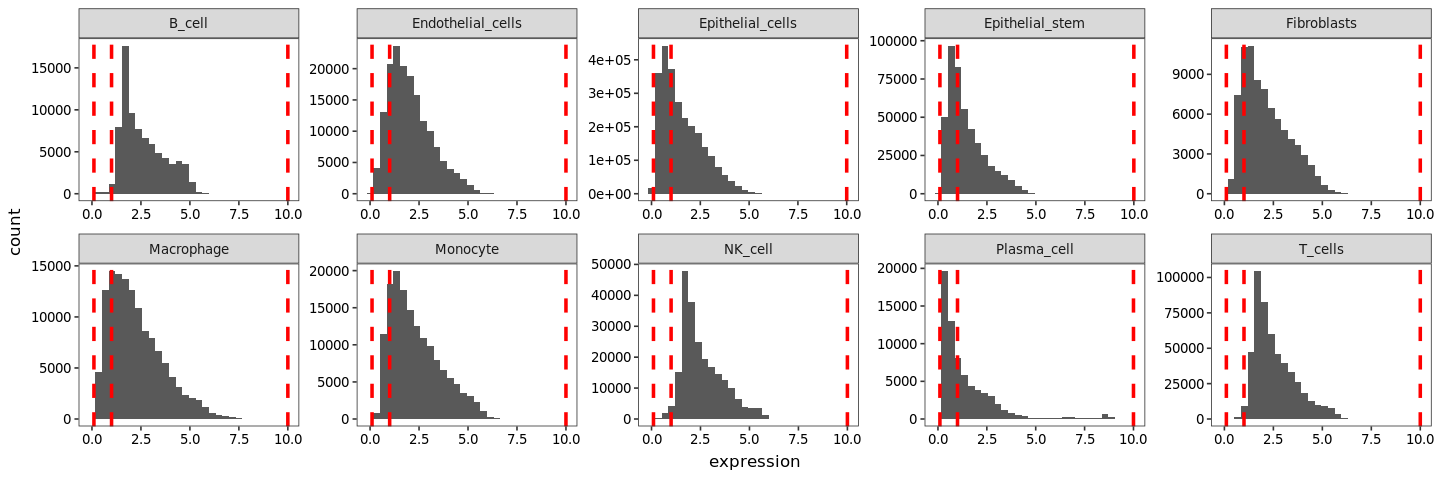

In [45]:
options(repr.plot.width = 12, repr.plot.height = 4)
dat_combined_norm$pl

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 61707 rows containing non-finite values (stat_bin)."Warning message:
"Removed 20 rows containing missing values (geom_bar)."Warning message:
"Removed 10 rows containing missing values (geom_vline)."

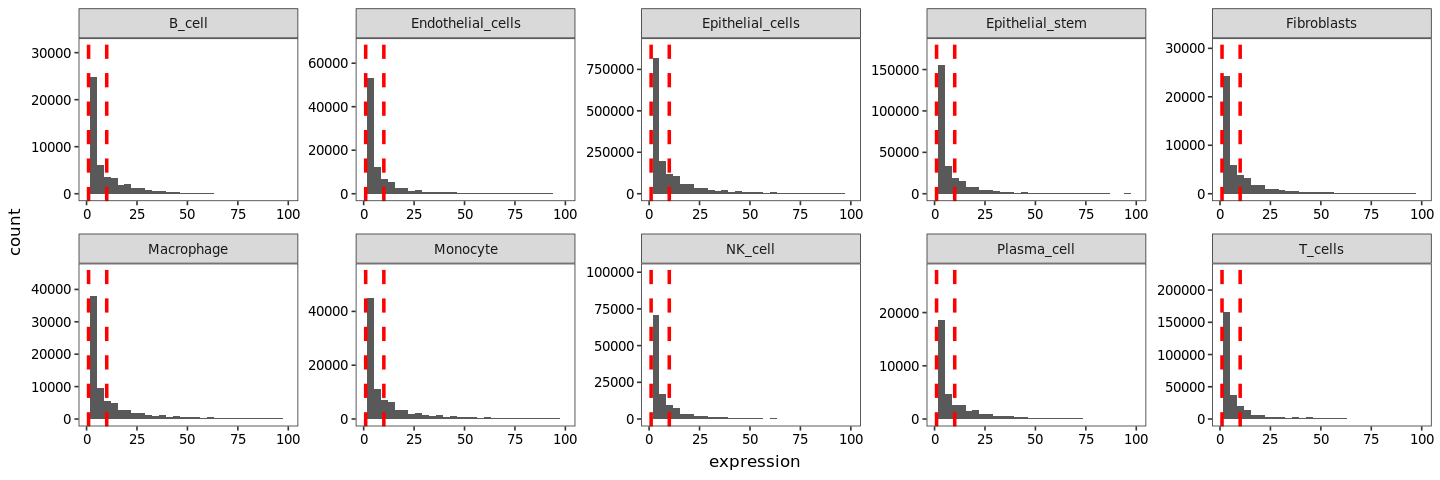

In [46]:
options(repr.plot.width = 12, repr.plot.height = 4)
dat_combined_raw$pl+xlim(1,100)

In [47]:
gene_stats_annot=merge(dat_combined_norm$stats,combined_red,by="gene")
gene_stats_annot=merge(dat_combined_raw$stats,gene_stats_annot,by=c("gene","labels"))

In [48]:
gene_stats_annot[gene=="HLA-B"]

gene  labels            mean_raw  sd_raw    median_raw max_raw min_raw
1  HLA-B B_cell             5.518155  6.503317  4         149     0      
2  HLA-B Endothelial_cells 16.253656 26.316181  9         451     0      
3  HLA-B Epithelial_cells  21.508163 34.994116  6         387     0      
4  HLA-B Epithelial_stem    3.236753  5.322194  2          78     0      
5  HLA-B Fibroblasts        6.116592 10.437063  3          85     0      
6  HLA-B Macrophage        22.429352 27.397635 12         228     0      
7  HLA-B Monocyte          17.000000 16.007772 12          88     0      
8  HLA-B NK_cell           10.757705  7.600902  9         108     0      
9  HLA-B Plasma_cell       40.422535 30.187655 36         313     1      
10 HLA-B T_cells            9.692515  6.850924  8          84     0      
   perc_expr_raw N_expr_raw mean_norm sd_norm   median_norm max_norm min_norm 
1  0.9617272       980      2.880455  0.8585813 3.006748    4.851620 0.0000000
2  0.9603009      2298      3.197122  0.9585465 3.296752    5.364325 0.0000000
3  0.8360291     22174      2.089291  1.3252704 2.278165    5.532898 0.0000000
4  0.7022043      3313      1.001149  0.8403541 1.006916    4.413509 0.0000000
5  0.8116592       181      2.093954  1.2694166 2.121967    4.581749 0.0000000
6  0.9692833      1420      3.314967  0.8829259 3.469489    5.349409 0.0000000
7  0.9801980       198      3.249717  0.7857381 3.360996    4.655546 0.0000000
8  0.9948630      3486      3.779097  0.6351783 3.844152    5.416769 0.0000000
9  1.0000000       639      3.003658  0.6284497 3.045122    5.324837 0.6364702
10 0.9936437      6253      3.594400  0.6754359 3.651689    5.476862 0.0000000
   perc_expr_norm N_expr_norm
1  0.9617272        980      
2  0.9603009       2298      
3  0.8360291      22174      
4  0.7022043       3313      
5  0.8116592        181      
6  0.9692833       1420      
7  0.9801980        198      
8  0.9948630       3486      
9  1.0000000        639      
10 0.9936437       6253      
   type                                                
1  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
2  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
3  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
4  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
5  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
6  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
7  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
8  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
9  immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
10 immune|malignant_t10_GO:0002480|B_cell_t2_GO:0019221
   method                    N_listed variability N_expr_all perc_expr_all
1  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
2  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
3  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
4  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
5  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
6  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
7  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
8  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
9  codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
10 codex_frozen|topics_fresh 3        0.3329212   53994      0.878494     
   mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority
1  1628.638      11          15          15            1       
2  1628.638      11          15          15            1       
3  1628.638      11          15          15            1       
4  1628.638      11          15          15            1       
5  1628.638      11          15          15            1       
6  1628.638      11          15          15            1       
7  1628.638      11          15          15            1       
8  1628.638      11          15      

In [49]:
write.table(gene_stats_annot,paste0("candidate_gene_stats_V3_topics.tsv"),sep="\t",quote=FALSE,row.names=FALSE)

In [9]:
#gene_stats_annot=fread(paste0("candidate_gene_stats_V3_topics.tsv"))

#### now reduce complexity, by only listing stats for the highest expressing cell type or for them malignant categories maximum of epithelial or epithelial_stem

In [10]:
#"Proliferation","Senescence","Apoptosis"
malignant_processes=c("Mammary","Luminal_","Myoepithelial","Basal[^+-]","Ductal","EMT","ER signaling","Resistance","Receptors")

In [11]:
gene_stats_annot_red_pre=gene_stats_annot[!(grepl(paste0(malignant_processes,collapse = "|"),type)&!labels%in%c("Epithelial_cells","Epithelial_stem"))]

In [12]:
#test that only Epithelial cell types are kept for malignant processes
cat(unique(gene_stats_annot_red_pre[grepl(paste0(malignant_processes,collapse = "|"),type)]$labels))

Epithelial_cells Epithelial_stem

In [13]:
#test that all cell types are kept for other processed
cat(unique(gene_stats_annot_red_pre[!grepl(paste0(malignant_processes,collapse = "|"),type)]$labels))

B_cell Endothelial_cells Epithelial_cells Epithelial_stem Fibroblasts Macrophage Monocyte NK_cell Plasma_cell T_cells

In [14]:
gene_stats_annot_red=gene_stats_annot_red_pre[,.SD[which.max(mean_norm)],by="gene"]
head(gene_stats_annot_red[gene%in%c("CD3D","EPCAM","CD19","DCN","PECAM1","CD163")])

gene   labels            mean_raw   sd_raw     median_raw max_raw min_raw
1 CD163  Monocyte           1.3663366  2.0331715 1           12     0      
2 CD19   B_cell             0.3562316  0.6026203 0            3     0      
3 CD3D   T_cells            2.1468298  1.7787833 2           26     0      
4 DCN    Fibroblasts       15.5246637 23.2667274 5          130     0      
5 EPCAM  Epithelial_cells   5.5094446  9.0276962 3          182     0      
6 PECAM1 Endothelial_cells  2.3903051  3.2805966 1           40     0      
  perc_expr_raw N_expr_raw mean_norm sd_norm   median_norm max_norm min_norm
1 0.5198020       105      0.9091792 1.0157318 0.7255274   3.582547 0       
2 0.2973503       303      0.5235321 0.8243686 0.0000000   2.713668 0       
3 0.8461783      5325      2.0030310 0.9995366 2.2254490   4.151919 0       
4 0.6905830       154      2.4670225 1.8623124 2.9796595   5.791456 0       
5 0.7799646     20687      1.2654198 0.8366835 1.4015614   4.293549 0       
6 0.6949436      1663      1.3472775 1.0044776 1.5826264   4.350673 0       
  perc_expr_norm N_expr_norm
1 0.5198020        105      
2 0.2973503        303      
3 0.8461783       5325      
4 0.6905830        154      
5 0.7799646      20687      
6 0.6949436       1663      
  type                                                                 
1 macro_mono|immune|MonoMacro+                                         
2 B_cells|immune                                                       
3 T_cells|immune|T_cells+                                              
4 CAFs|Fibroblasts+|Fibroblasts_t3_GO:0030198|Fibroblasts_t4_GO:0071345
5 Epithelial|Mammary lineage                                           
6 Endothelial|stroma                                                   
  method                                            N_listed variability
1 interest_ct|mibi_fixed|data_ct_frozen             3        0.02474700 
2 interest_ct|codex_frozen                          2        0.01584719 
3 interest_ct|codex_frozen|mibi_fixed|data_ct_fresh 4        0.17474212 
4 interest_ct|data_ct_fresh|topics_fresh            4        0.03358173 
5 interest_ct|interest_mbc                          2        0.23896066 
6 interest_ct|codex_frozen|mibi_fixed               3        0.06800950 
  N_expr_all perc_expr_all mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order
1  1539      0.02503986     40.017516    NA           5          100          
2   976      0.01587973      2.762072    NA          NA          438          
3 11436      0.18606619     22.012408     3           4           63          
4  2308      0.03755166    152.923088     5           6          213          
5 26242      0.42696300    210.194041    NA          NA          342          
6  4646      0.07559142            NA    NA          NA          248          
  priority 
1 1.0000000
2 1.0000000
3 1.0000000
4 0.2819964
5 1.0000000
6 1.0000000

In [55]:
write.table(gene_stats_annot_red,paste0("candidate_gene_stats_red_V3_topics.tsv"),sep="\t",quote=FALSE,row.names=FALSE)

In [240]:
#gene_stats_annot_red=fread("candidate_gene_stats_red_V3.tsv")

### Now filter

In [154]:
#settings without topics
#var_thres=0.015
#var_thres_s=0.12
#exp_thres=0.1
#exp_thres_s=1

var_thres=0.025
var_thres_s=0.25
exp_thres=0.25
exp_thres_s=1.5
exp_thres_sh=4


perc_expr_thres=0.1

Warning message:
"Removed 11 rows containing missing values (geom_point)."

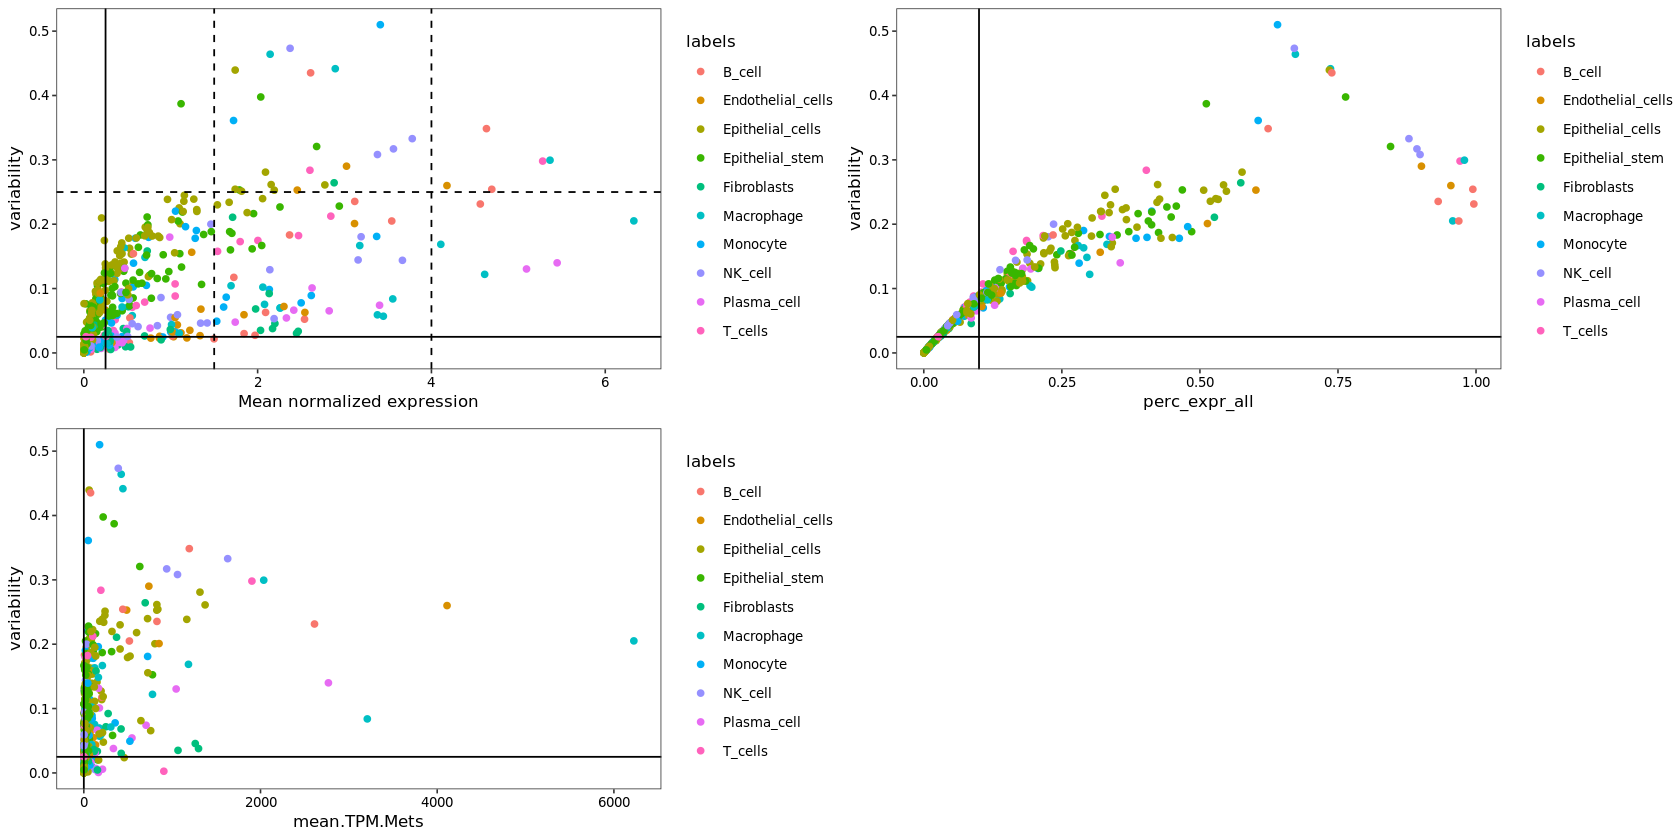

In [155]:
options(repr.plot.width = 14, repr.plot.height = 7)
p1=ggplot(gene_stats_annot_red,aes(x=mean_norm,y=variability,col=labels))+geom_point()+geom_hline(yintercept = c(var_thres,var_thres_s),lty=c(1,2))+geom_vline(xintercept = c(exp_thres,exp_thres_s,exp_thres_sh),lty=c(1,2,2))+xlab("Mean normalized expression")
p2=ggplot(gene_stats_annot_red,aes(x=perc_expr_all,y=variability,col=labels))+geom_point()+geom_hline(yintercept = var_thres)+geom_vline(xintercept = perc_expr_thres)
p3=ggplot(gene_stats_annot_red,aes(x=mean.TPM.Mets,y=variability,col=labels))+geom_point()+geom_hline(yintercept = var_thres)+geom_vline(xintercept = perc_expr_thres)
plot_grid(p1,p2,p3)

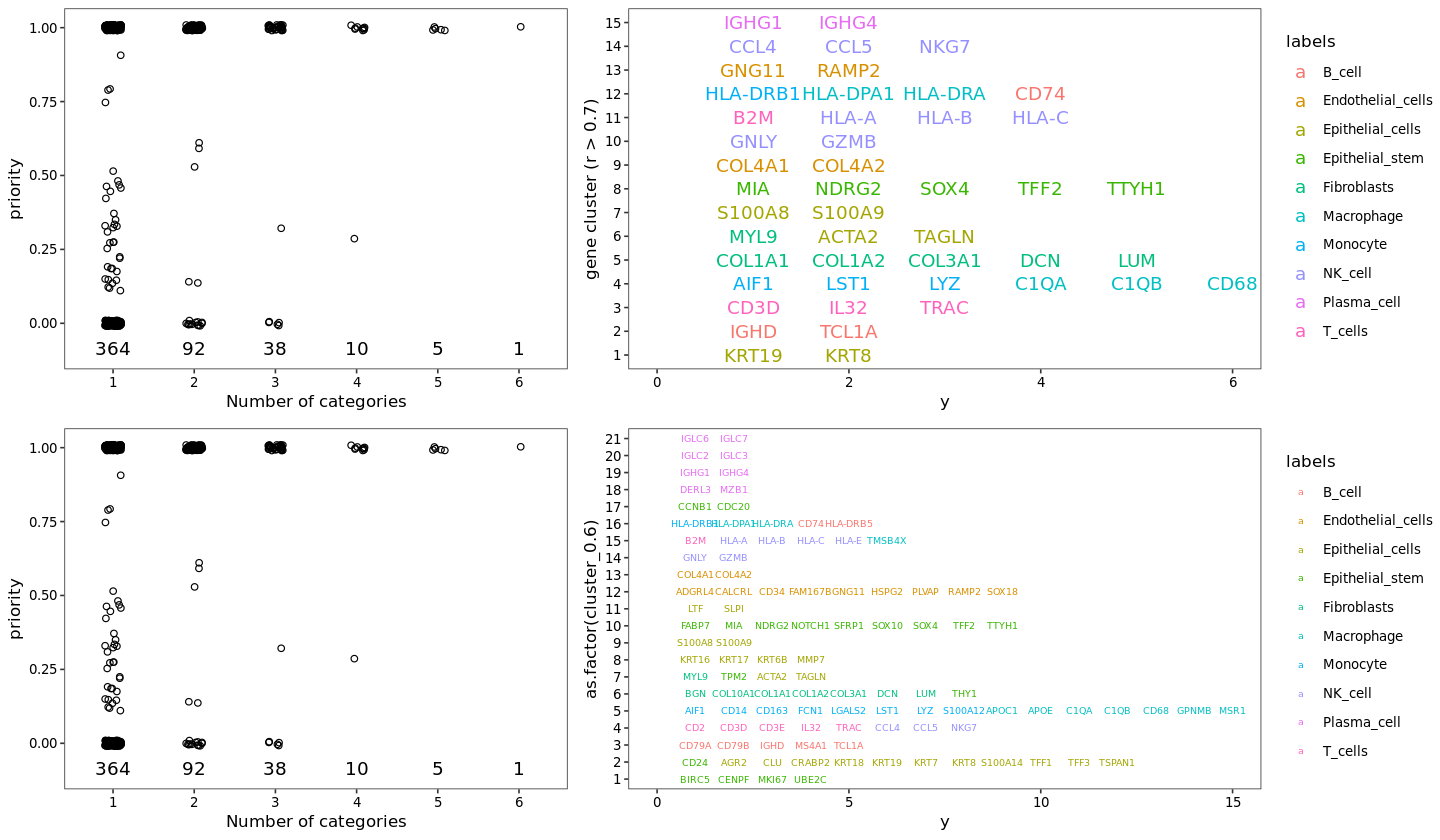

In [156]:
options(repr.plot.width = 12, repr.plot.height = 7)
p1=ggplot(gene_stats_annot_red,aes(x=as.factor(N_listed)))+geom_point(aes(y=priority),shape=21,position=position_jitter(width=0.1,height=0.01))+
geom_text(stat='count',y=-0.15, aes(label=..count..), vjust=-1)+ylim(c(-0.1,1.01))+xlab("Number of categories")
p2=ggplot(gene_stats_annot_red[!is.na(cluster_0.7)],aes(x=as.factor(cluster_0.7),y=1,col=labels))+geom_text(aes(label=gene),position=position_stack())+coord_flip()+xlab("gene cluster (r > 0.7)")
p3=ggplot(gene_stats_annot_red[!is.na(cluster_0.6)],aes(x=as.factor(cluster_0.6),y=1,col=labels))+geom_text(aes(label=gene),size=2,position=position_stack())+coord_flip()
plot_grid(p1,p2,p1,p3,rel_widths = c(1,1.5))

In [282]:
#fill up for without topics
#ad priority 1 to interest genes to fill up of "NF1","KRAS", "BRAF","MAPK3"
#gene_stats_annot_red[gene%in%c("NF1","KRAS", "BRAF","MAPK3"),priority:=1,]

In [157]:
#add priority 1 to special interest genes
gene_stats_annot_red[gene%in%c("KRAS", "AKT1","MAPK3","NF1","BRAF","MAPK13"),priority:=1,]

replaced by special interest genes: FCRL5,IL3RA

In [158]:
#sel=gene_stats_annot_red[(mean_norm>exp_thres|variability>var_thres|N_listed>1)&(priority==1|(N_listed>1&!grepl("pam50",method))|(N_listed>2&grepl("pam50",method)))]
sel=gene_stats_annot_red[(mean_norm>exp_thres|variability>var_thres|N_listed>1)&((mean_norm>exp_thres_s&mean_norm<exp_thres_sh)|variability>var_thres_s|priority==1|(N_listed>1&!grepl("pam50",method))|(N_listed>2&grepl("pam50",method)))]

length(unique(sel$gene))
length(unique(unlist(strsplit(sel$method,"\\|"))))
length(unique(unlist(strsplit(sel$type,"\\|"))))
cat(gene_stats_annot_red[grepl("interest_mbc",method)&priority==1&!gene%in%sel$gene]$gene)
unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))[!unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))%in%unique(unlist(strsplit(sel$type,"\\|")))]

[1] 300

[1] 9

[1] 82

DLC1 FGF1 FGF2 FGF3 FGF4 FGFR3 GREB1 KRT6A MME TP63

[1] "Epithelial_cells-"

In [159]:
head(sel)

gene   labels            mean_raw  sd_raw    median_raw max_raw min_raw
1 ACTA2  Epithelial_cells  0.1018361  1.621112 0          167     0      
2 ACTG2  Epithelial_stem   0.2191607  1.517573 0           44     0      
3 ACTR3B Epithelial_stem   1.0671895  1.587508 0           16     0      
4 ADGRL4 Endothelial_cells 1.5988299  2.364106 1           22     0      
5 AGR2   Epithelial_cells  8.0870565 18.664257 1          502     0      
6 AHR    Monocyte          0.2524752  0.537748 0            2     0      
  perc_expr_raw N_expr_raw mean_norm  sd_norm   median_norm max_norm min_norm
1 0.04633714     1229      0.03245257 0.2034610 0.0000000   4.249573 0       
2 0.08732514      412      0.08309732 0.3253533 0.0000000   4.255461 0       
3 0.49597287     2340      0.48466996 0.5570544 0.0000000   3.126168 0       
4 0.59506895     1424      1.03305602 0.9504032 1.1902205   3.521134 0       
5 0.55532934    14729      1.10769292 1.1850340 0.8444383   4.972475 0       
6 0.20297030       41      0.24882331 0.5425153 0.0000000   2.573111 0       
  perc_expr_norm N_expr_norm
1 0.04611092      1223      
2 0.08732514       412      
3 0.49597287      2340      
4 0.59506895      1424      
5 0.55517852     14725      
6 0.20297030        41      
  type                                                
1 Myoepithelial|Fibroblasts+|Fibroblasts_t2_GO:0006936
2 Myoepithelial|Fibroblasts_t2_GO:0006936             
3 Basal+                                              
4 Endothelial_cells+                                  
5 Luminal_hormone_resp. (L2)                          
6 Epithelial_cells+                                   
  method                                  N_listed variability N_expr_all
1 interest_mbc|data_ct_fresh|topics_fresh 3        0.04780189   4040     
2 interest_mbc|topics_fresh               2        0.02282711   1490     
3 pam50_fresh|pam50_frozen                2        0.10839218   8471     
4 data_ct_frozen                          1        0.02508867   1554     
5 interest_mbc                            1        0.20072565  16023     
6 data_ct_frozen                          1        0.05094205   3563     
  perc_expr_all mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority
1 0.06573167    220.934864     6           7          196           1       
2 0.02424262     35.076375    NA          NA          378           0       
3 0.13782500      8.902605    NA          NA          305           1       
4 0.02528392            NA    NA          12          244           1       
5 0.26069767    804.894807    NA           2          496           1       
6 0.05797078     32.640853    NA          NA          123           1

In [178]:
write.table(sel,"final_selection_300_V3_topics.tsv",quote=F,row.names=F,sep="\t")

In [161]:
unique(combined$type)[!unique(combined$type)%in%unique(unlist(strsplit(sel$type,"\\|")))]

[1] "Epithelial_cells-"

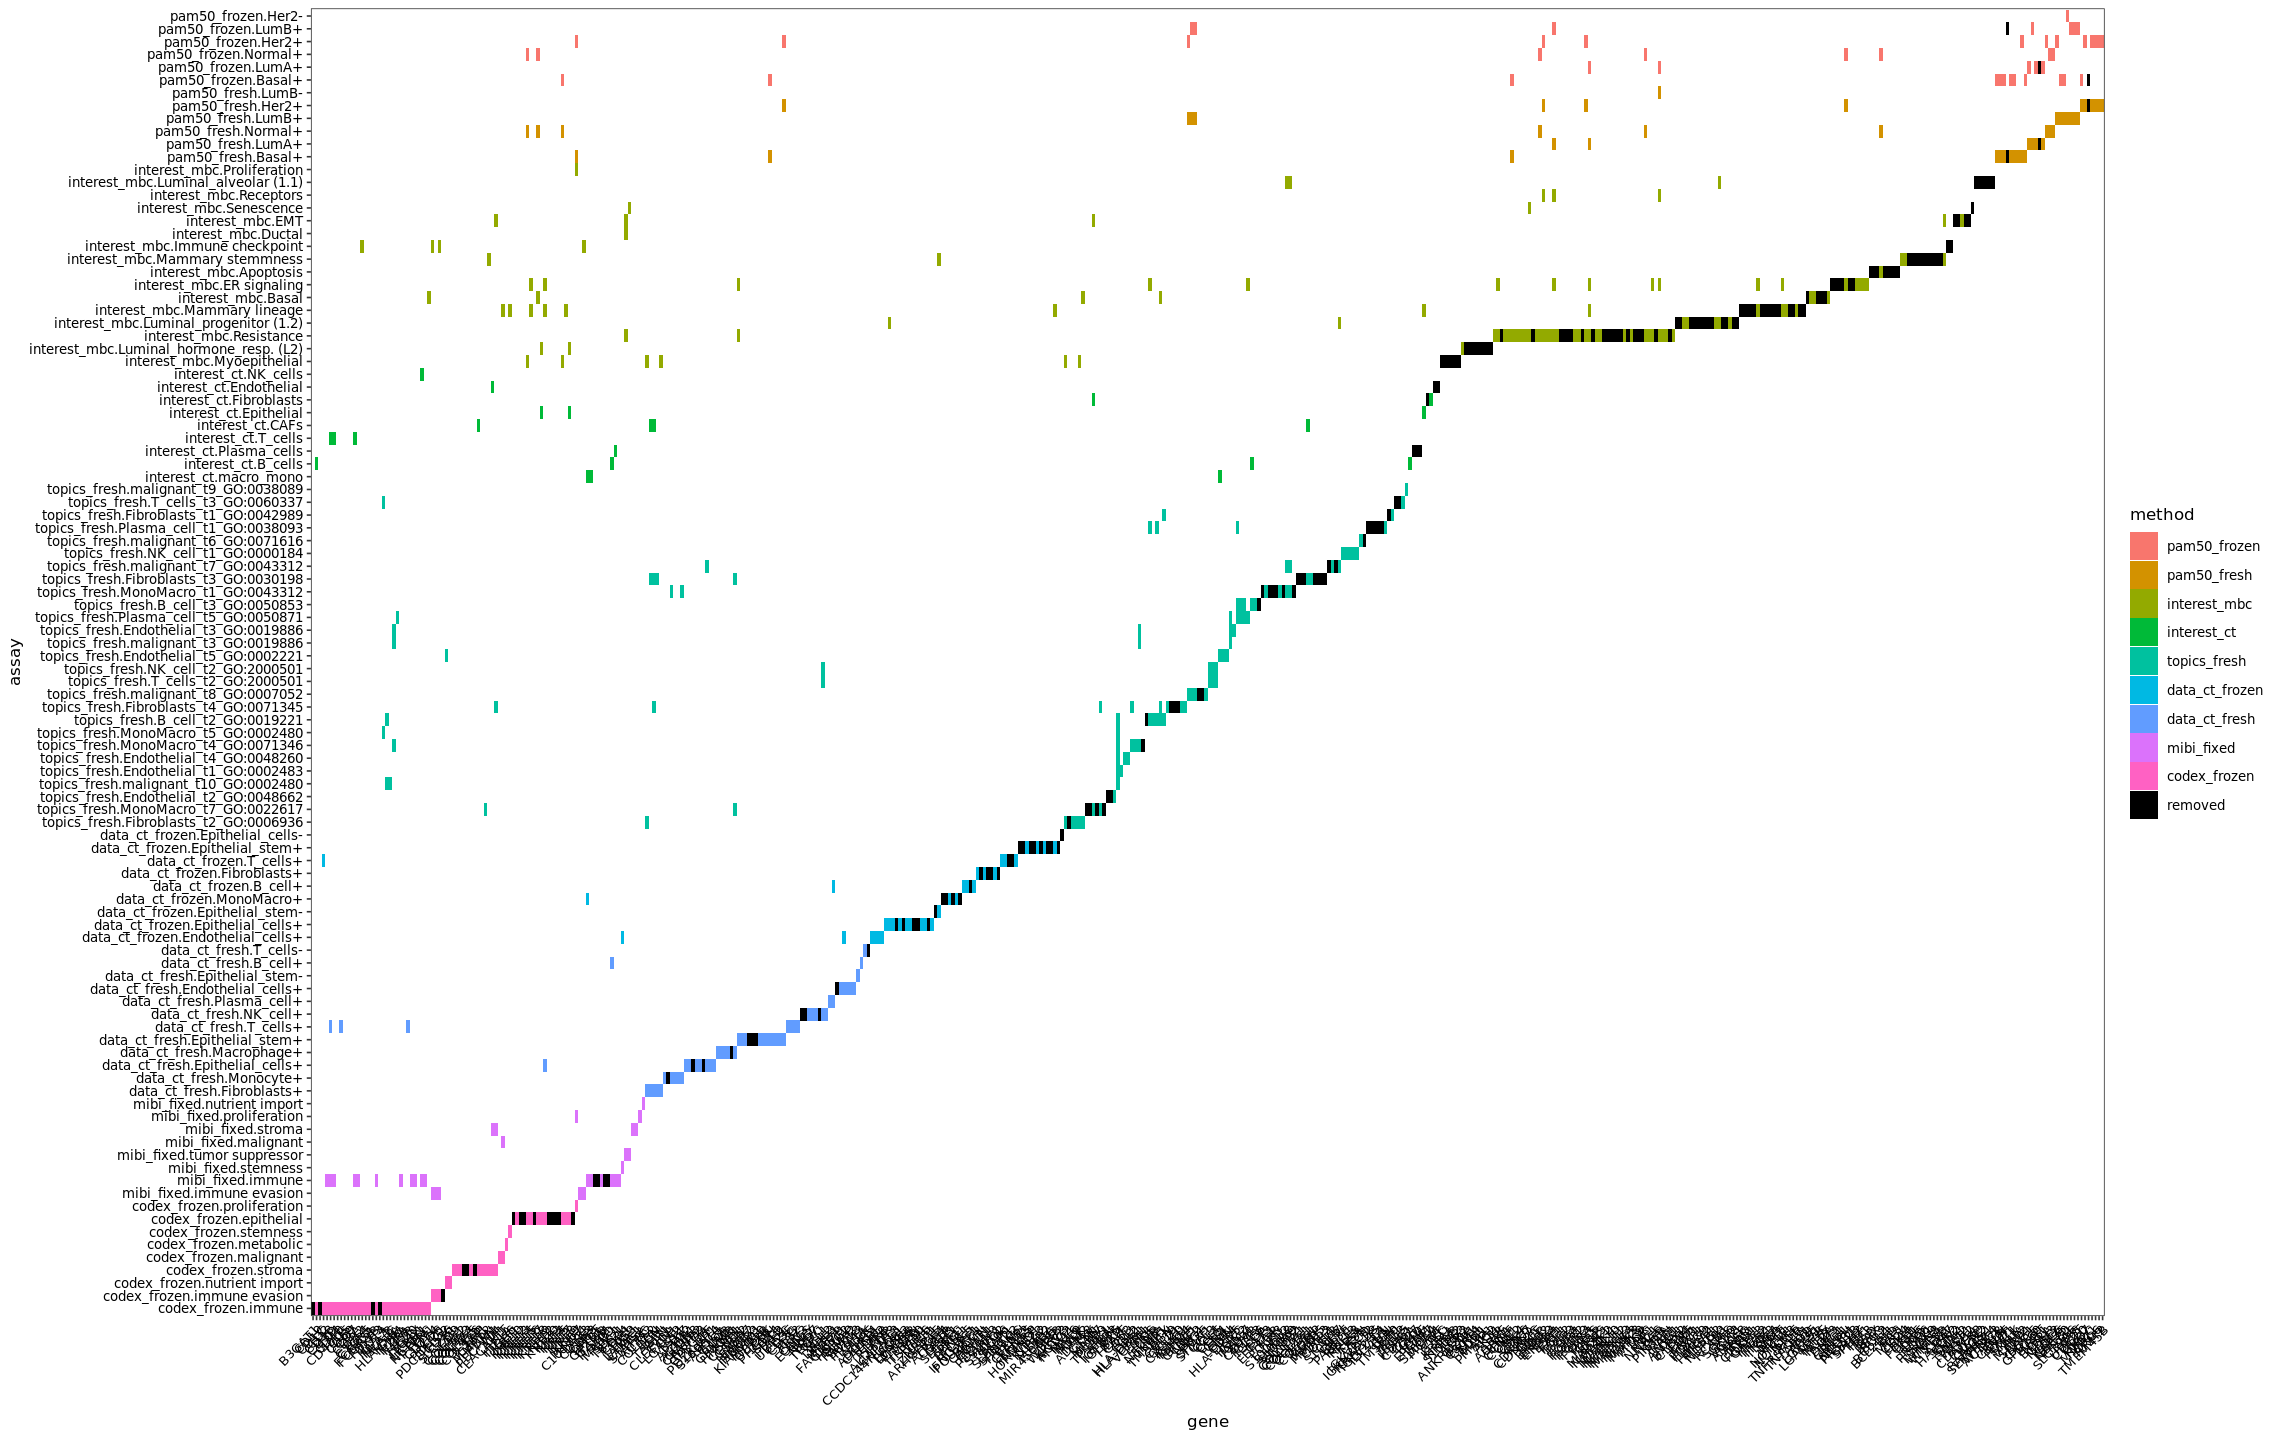

In [162]:
#all
options(repr.plot.width = 19, repr.plot.height = 12)
sub=combined[method!="codex_fixed"]
sub[,method:=factor(method,levels=c("pam50_frozen","pam50_fresh","interest_mbc","interest_ct","topics_fresh","data_ct_frozen","data_ct_fresh","mibi_fixed","codex_frozen","codex_fixed")),]
sub[,assay:=factor(assay,levels=unique(assay[order(method,decreasing=TRUE)])),]
sub[,gene:=factor(gene,levels=unique(gene[order(assay)])),]
sub[!gene%in%sel$gene,method:="removed",]
ggplot(sub,aes(x=gene,y=assay,fill=method))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_fill_manual(values = c(hue_pal()(9),"black"))

[1] 92

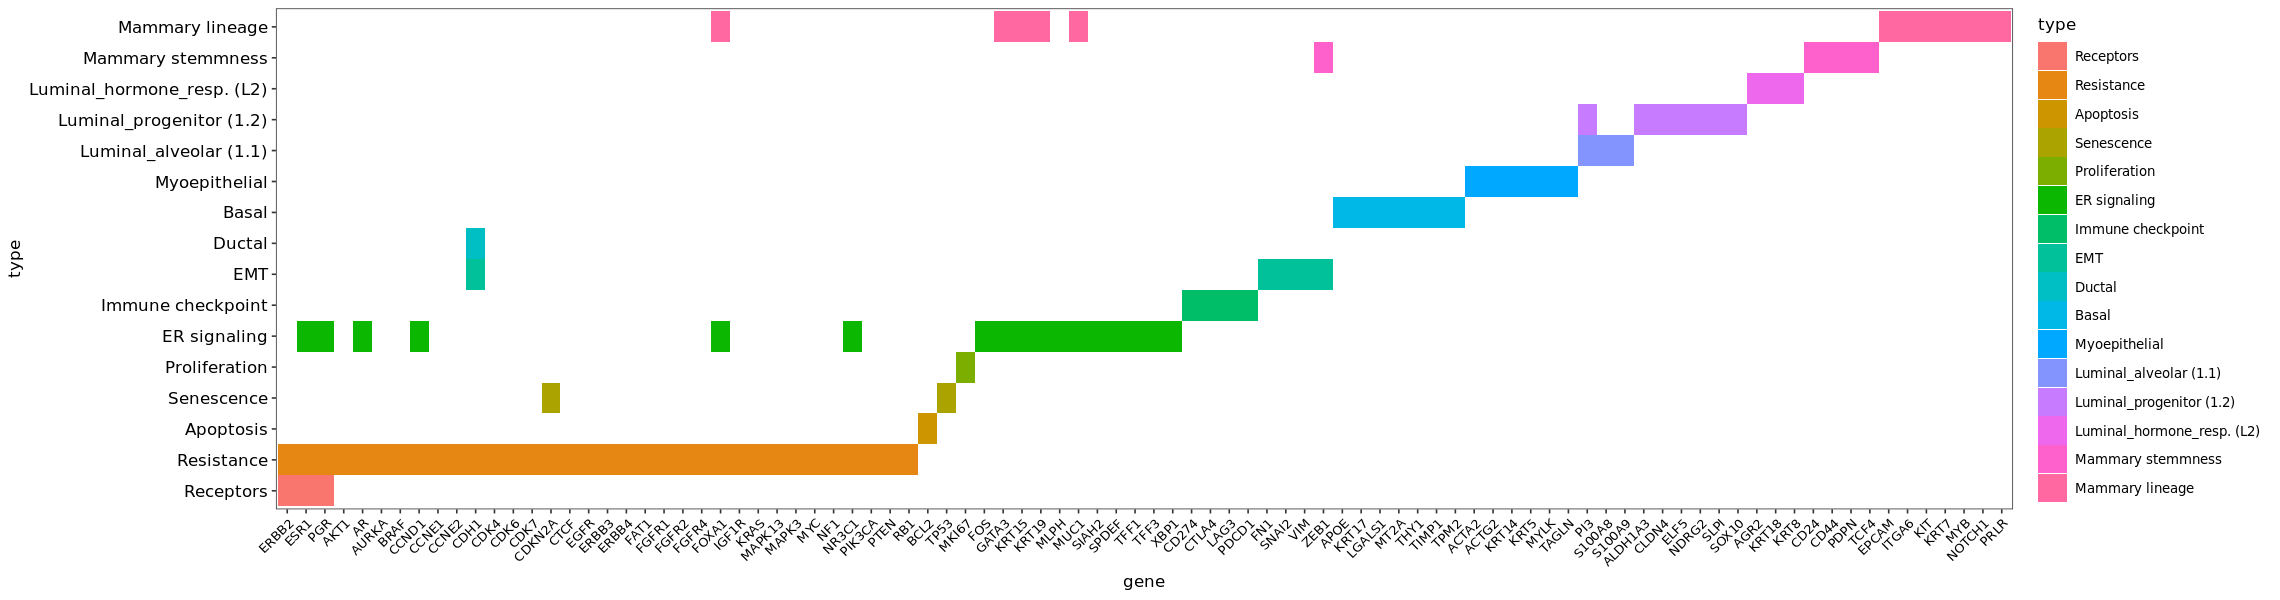

In [163]:
#interest MBC
options(repr.plot.width = 19, repr.plot.height = 5)
sub=combined[method=="interest_mbc"&gene%in%sel$gene]
sub[,type:=factor(type,levels=c("Receptors", "Resistance" , "Apoptosis", "Senescence", "Proliferation", "ER signaling", "Immune checkpoint", "EMT","Ductal", "Basal", "Myoepithelial", 
                                           "Luminal_alveolar (1.1)", "Luminal_progenitor (1.2)","Luminal_hormone_resp. (L2)","Mammary stemmness", "Mammary lineage"))]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)+theme(axis.text.y=element_text(size=10))
length(unique(sub$gene))

[1] 22

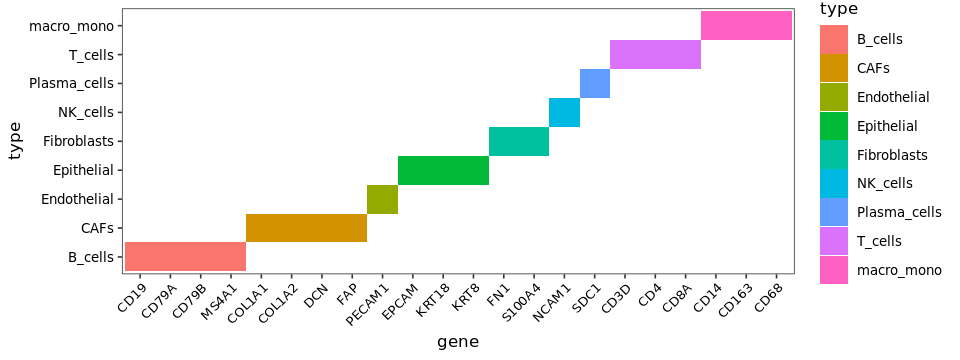

In [164]:
#interest ct
options(repr.plot.width = 8, repr.plot.height = 3)
sub=combined[method=="interest_ct"&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 47

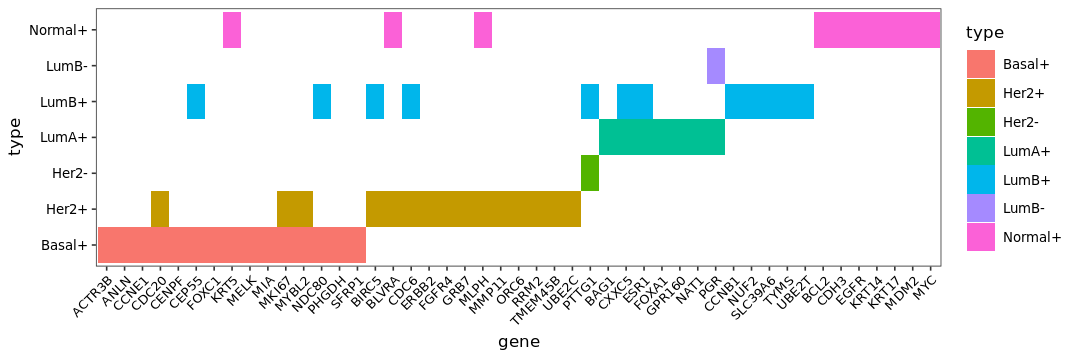

In [165]:
#pam50
options(repr.plot.width = 9, repr.plot.height = 3)
sub=combined[grepl("pam50",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 89

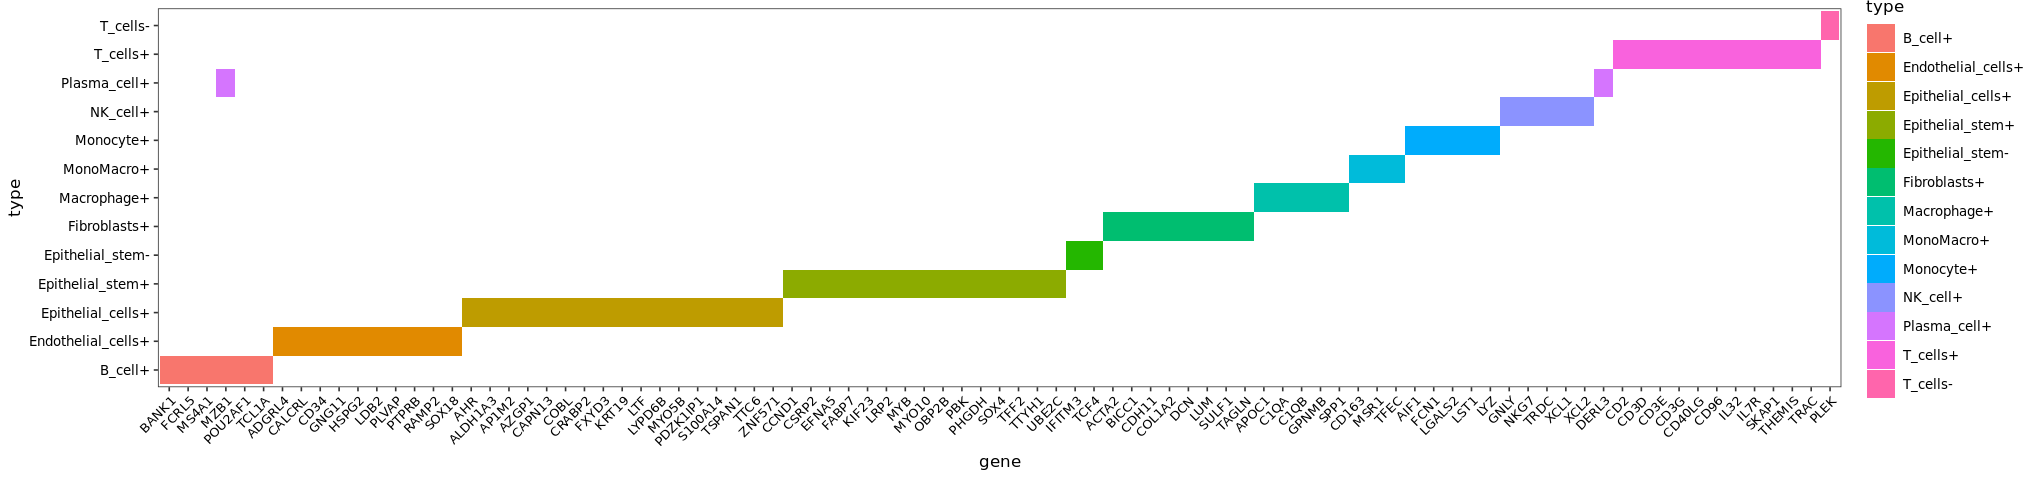

In [166]:
#data
options(repr.plot.width = 17, repr.plot.height = 4)
sub=combined[grepl("data",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 34

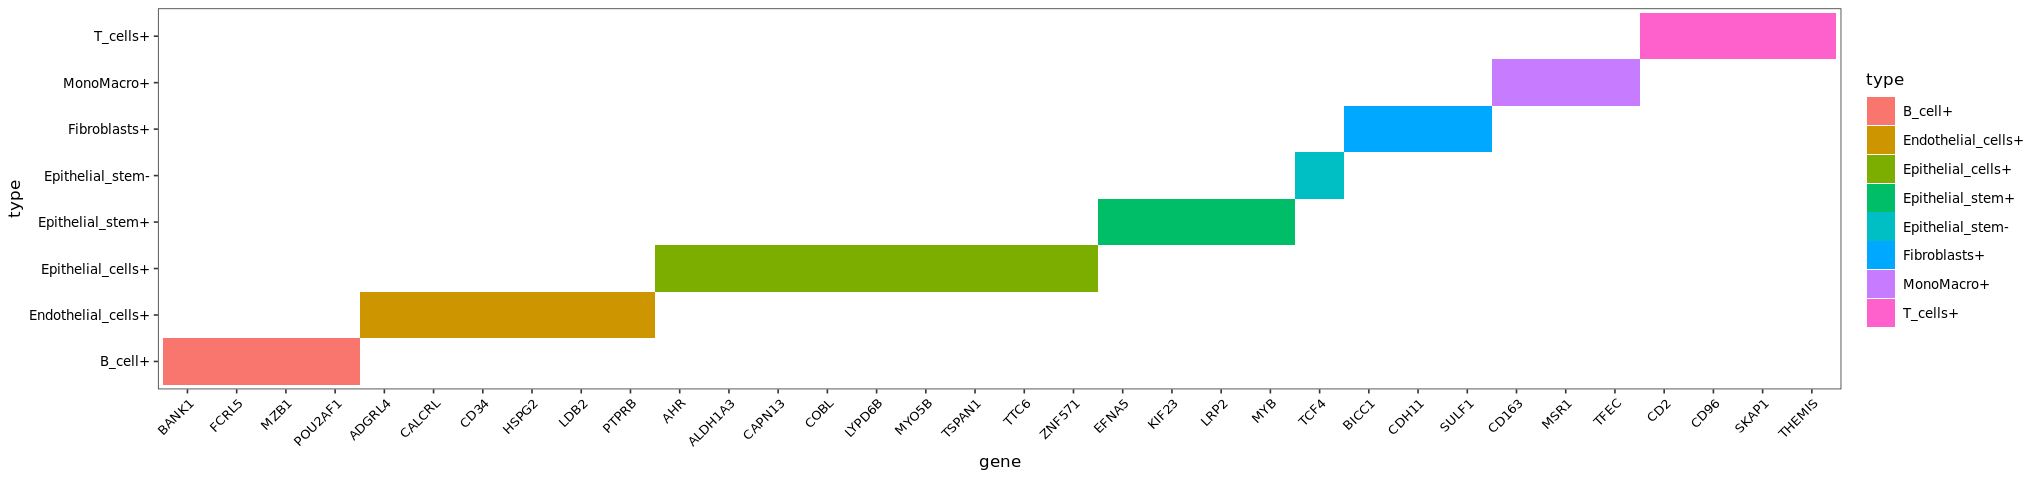

In [173]:
#data
options(repr.plot.width = 17, repr.plot.height = 4)
sub=combined[grepl("data_ct_frozen",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 57

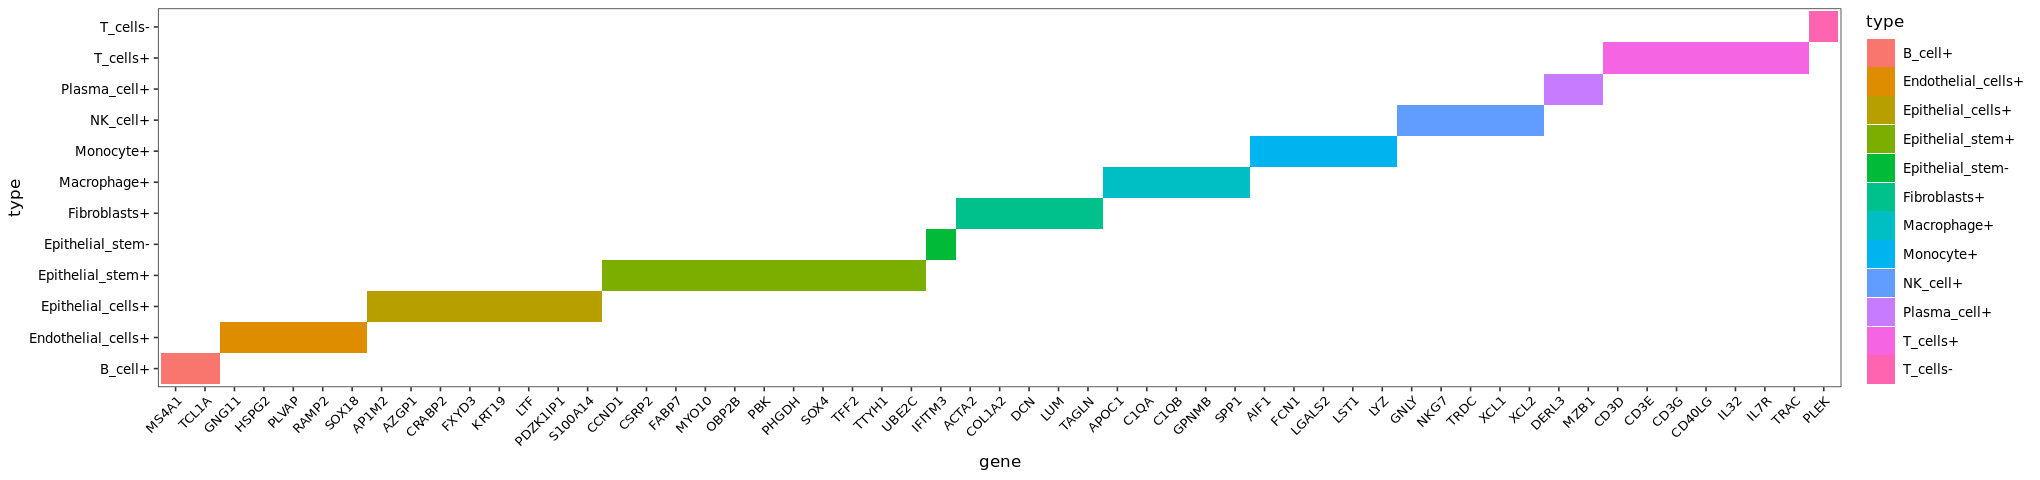

In [174]:
#data
options(repr.plot.width = 17, repr.plot.height = 4)
sub=combined[grepl("data_ct_fresh",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 76

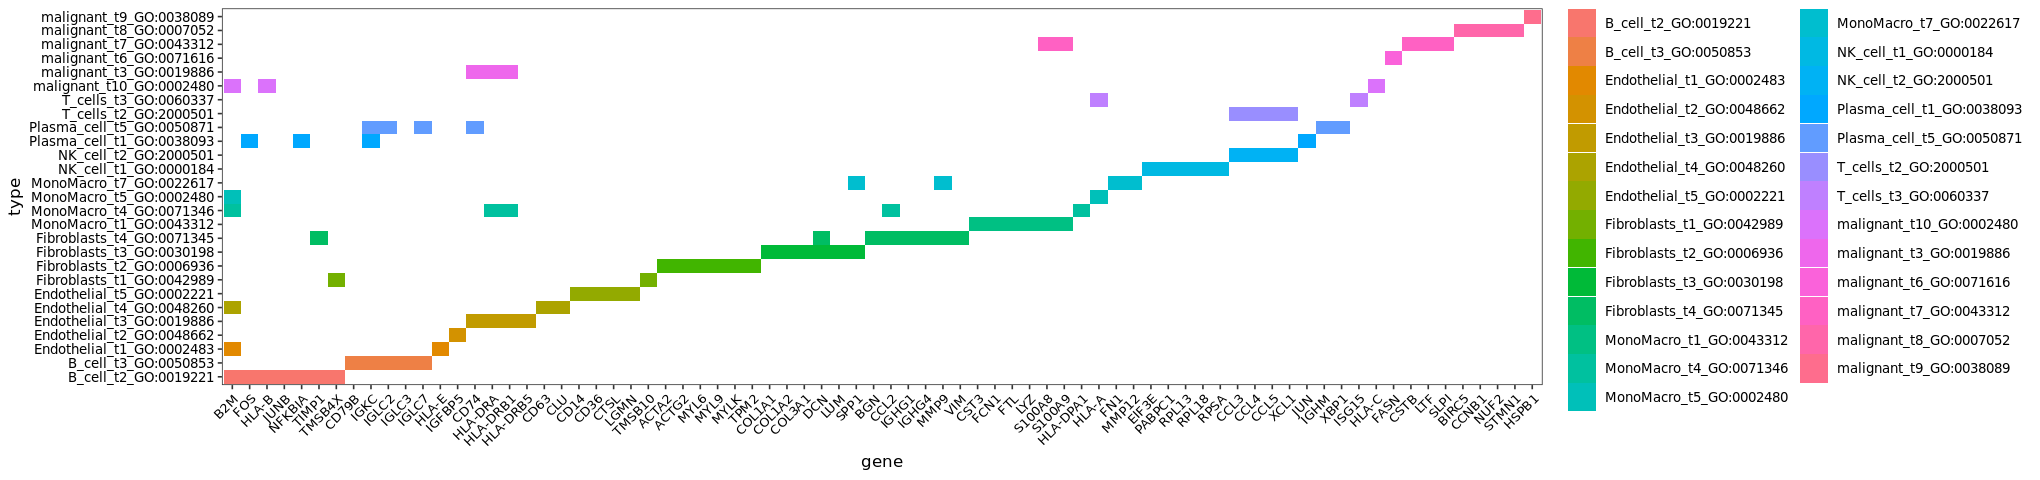

In [167]:
#topics
options(repr.plot.width = 17, repr.plot.height = 4)
sub=combined[grepl("topics",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)
length(unique(sub$gene))

[1] 74

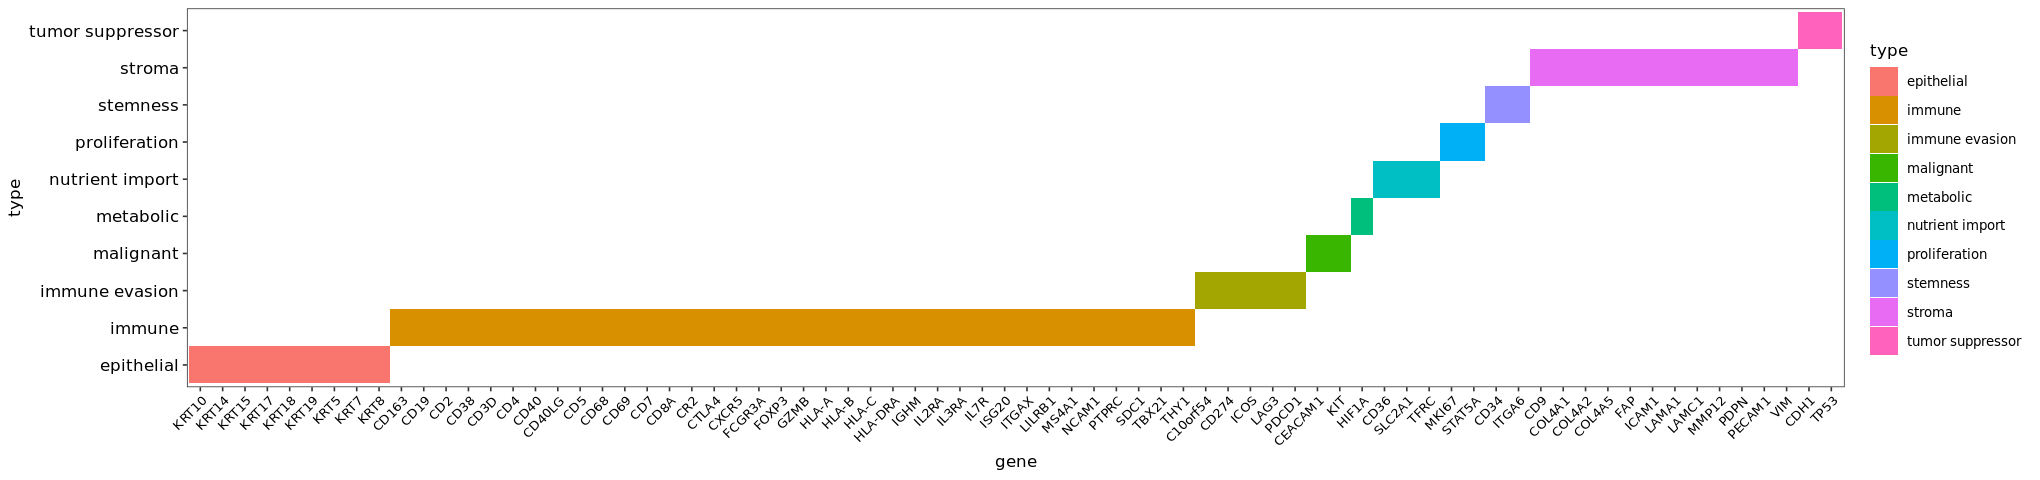

In [168]:
#mibi codex
options(repr.plot.width = 17, repr.plot.height = 4)
sub=combined[grepl("mibi|codex",method)&gene%in%sel$gene]
sub[,gene:=factor(gene,levels=unique(gene[order(type)])),]
ggplot(sub,aes(x=gene,y=type,fill=type))+geom_tile()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+scale_y_discrete(drop=FALSE)+theme(axis.text.y=element_text(size=10))
length(unique(sub$gene))

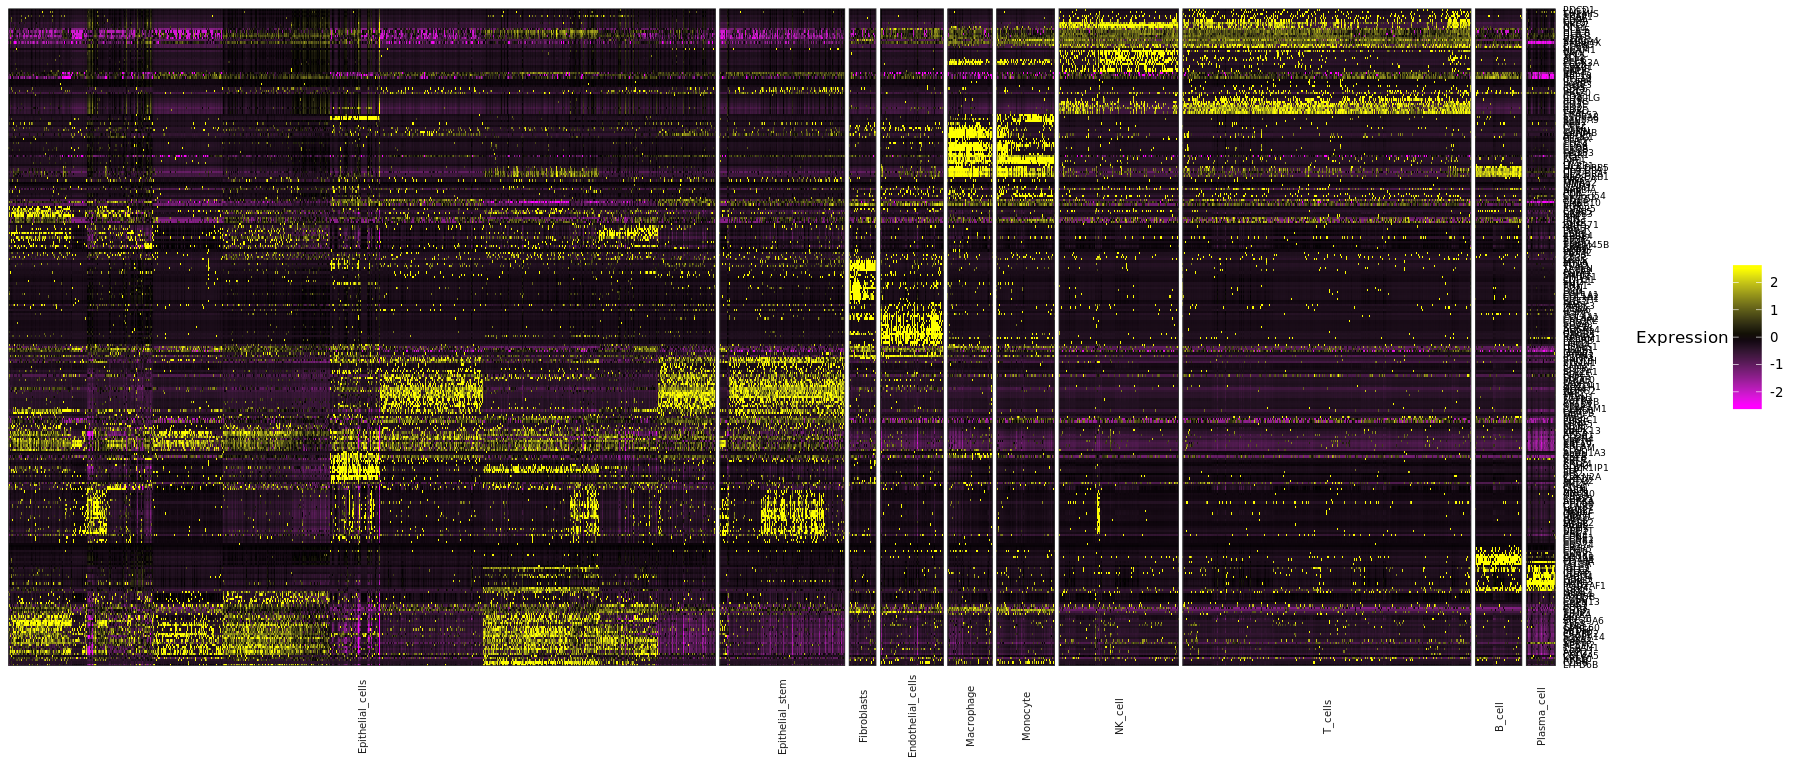

In [169]:
options(repr.plot.width = 15, repr.plot.height = 6.5)
DoHeatmap(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident = Inf),group.cex = 6,group.order = cell_types,slim.col.label = TRUE,group.label.rot = TRUE,
          draw.line = TRUE,genes.use = gene_stats_annot_red[gene%in%sel$gene][order(cluster_order)]$gene,group.by = "labels",cex.row = 5.5,cex.col = 0)

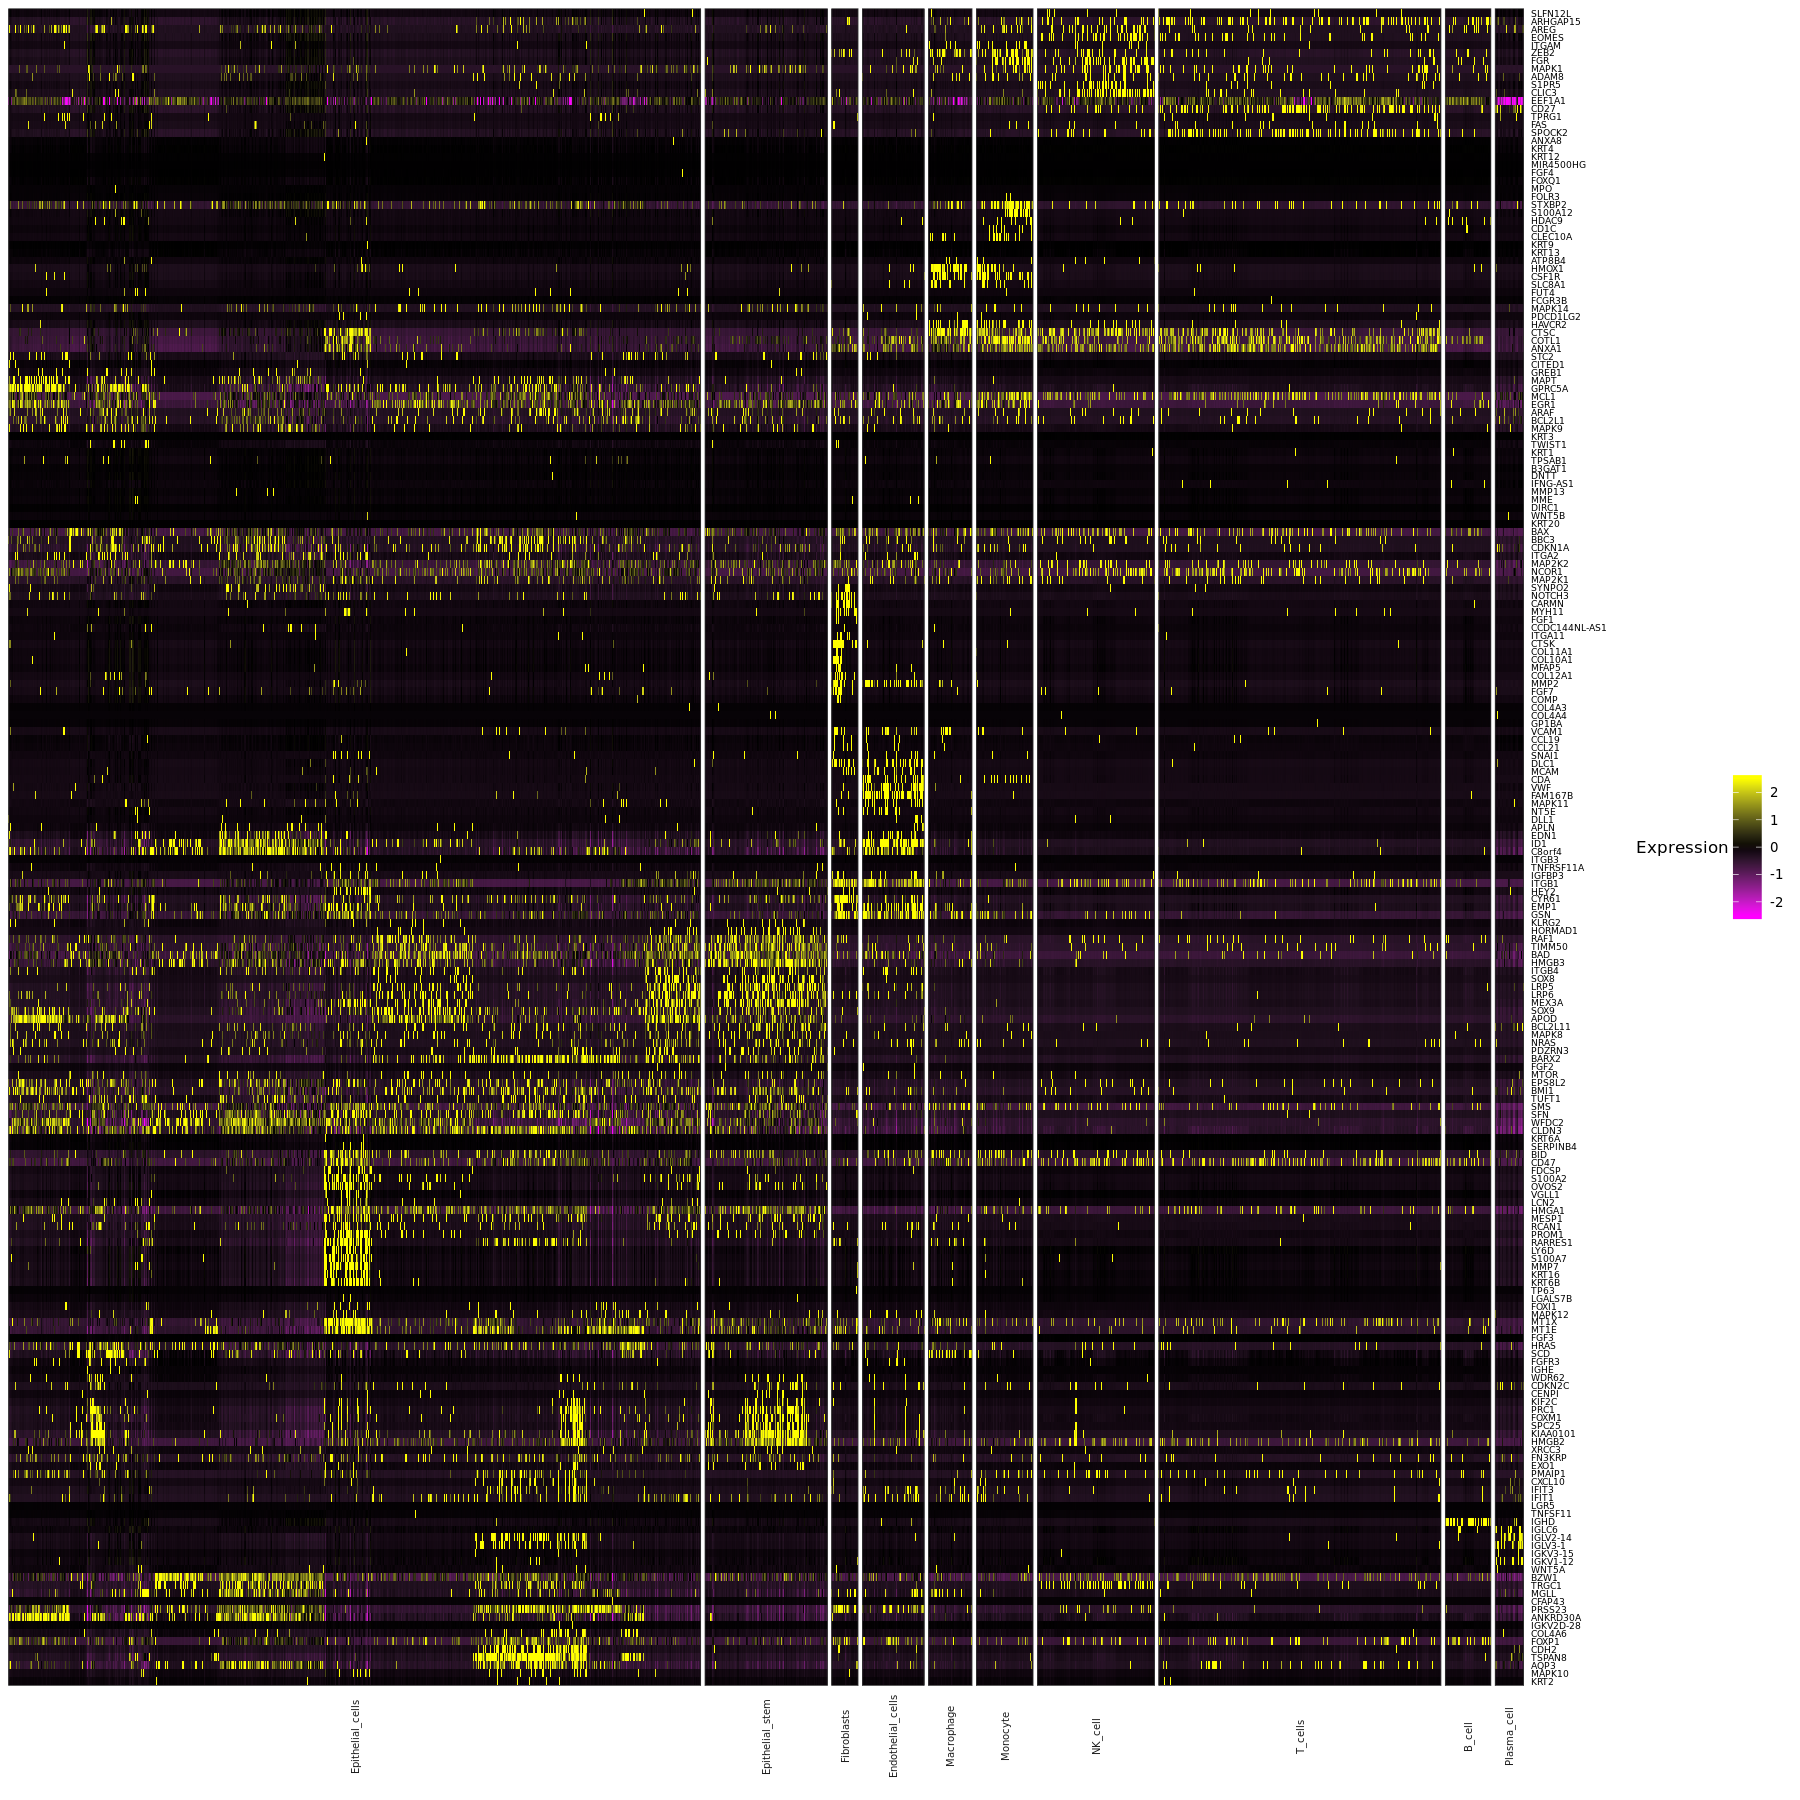

In [170]:
options(repr.plot.width = 15, repr.plot.height = 15)
DoHeatmap(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident = Inf),group.cex = 6,group.order = cell_types,slim.col.label = TRUE,group.label.rot = TRUE,
          draw.line = TRUE,genes.use = gene_stats_annot_red[!gene%in%sel$gene][order(cluster_order)]$gene,group.by = "labels",cex.row = 5.5,cex.col = 0)

In [177]:
nrow(md[labels%in%cell_types])
nrow(md)

[1] 56872

[1] 61462

### quick check stuff

In [100]:
gene_stats_annot_red[gene%in%c("FGF3","FGF4")]

gene labels          mean_raw    sd_raw     median_raw max_raw min_raw
1 FGF3 Epithelial_stem 0.001059771 0.03254032 0           1      0      
2 FGF4 Epithelial_stem 0.002331496 0.14630953 0          10      0      
  perc_expr_raw N_expr_raw mean_norm    sd_norm    median_norm max_norm
1 0.0010597711  5          0.0006214753 0.02580597 0           1.60402 
2 0.0004239084  2          0.0003986331 0.02234146 0           1.48194 
  min_norm perc_expr_norm N_expr_norm type       method       N_listed
1 0        0.0010597711   5           Resistance interest_mbc 1       
2 0        0.0004239084   2           Resistance interest_mbc 1       
  variability  N_expr_all perc_expr_all mean.TPM.Mets cluster_0.7 cluster_0.6
1 2.115128e-04 13         2.115128e-04  0.8603208     NA          NA         
2 6.508086e-05  4         6.508086e-05  0.2806915     NA          NA         
  cluster_order priority
1 384           1       
2  69           1

In [119]:
sel[gene%in%c("DUSP1", "DUSP2", "DUSP4", "DUSP5", "DUSP6", "DUSP7", "DUSP8", "DUSP9", "DUSP10", "DUSP14", "DUSP16" ,"DUSP26")]

gene labels mean_raw sd_raw median_raw max_raw min_raw perc_expr_raw
     N_expr_raw mean_norm sd_norm median_norm max_norm min_norm perc_expr_norm
     N_expr_norm type method N_listed variability N_expr_all perc_expr_all
     mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority

In [120]:
gene_stats_annot_red[gene%in%c("DUSP1", "DUSP2", "DUSP4", "DUSP5", "DUSP6", "DUSP7", "DUSP8", "DUSP9", "DUSP10", "DUSP14", "DUSP16" ,"DUSP26")]

gene labels mean_raw sd_raw median_raw max_raw min_raw perc_expr_raw
     N_expr_raw mean_norm sd_norm median_norm max_norm min_norm perc_expr_norm
     N_expr_norm type method N_listed variability N_expr_all perc_expr_all
     mean.TPM.Mets cluster_0.7 cluster_0.6 cluster_order priority

In [ ]:
c("MAPK8", "MAPK9", "MAPK10", "MAPK11", "MAPK12", "MAPK13", "MAPK14")
c("DUSP1", "DUSP2", "DUSP4", "DUSP5", "DUSP6", "DUSP7", "DUSP8", "DUSP9", "DUSP10", "DUSP14", "DUSP16" ,"DUSP26")

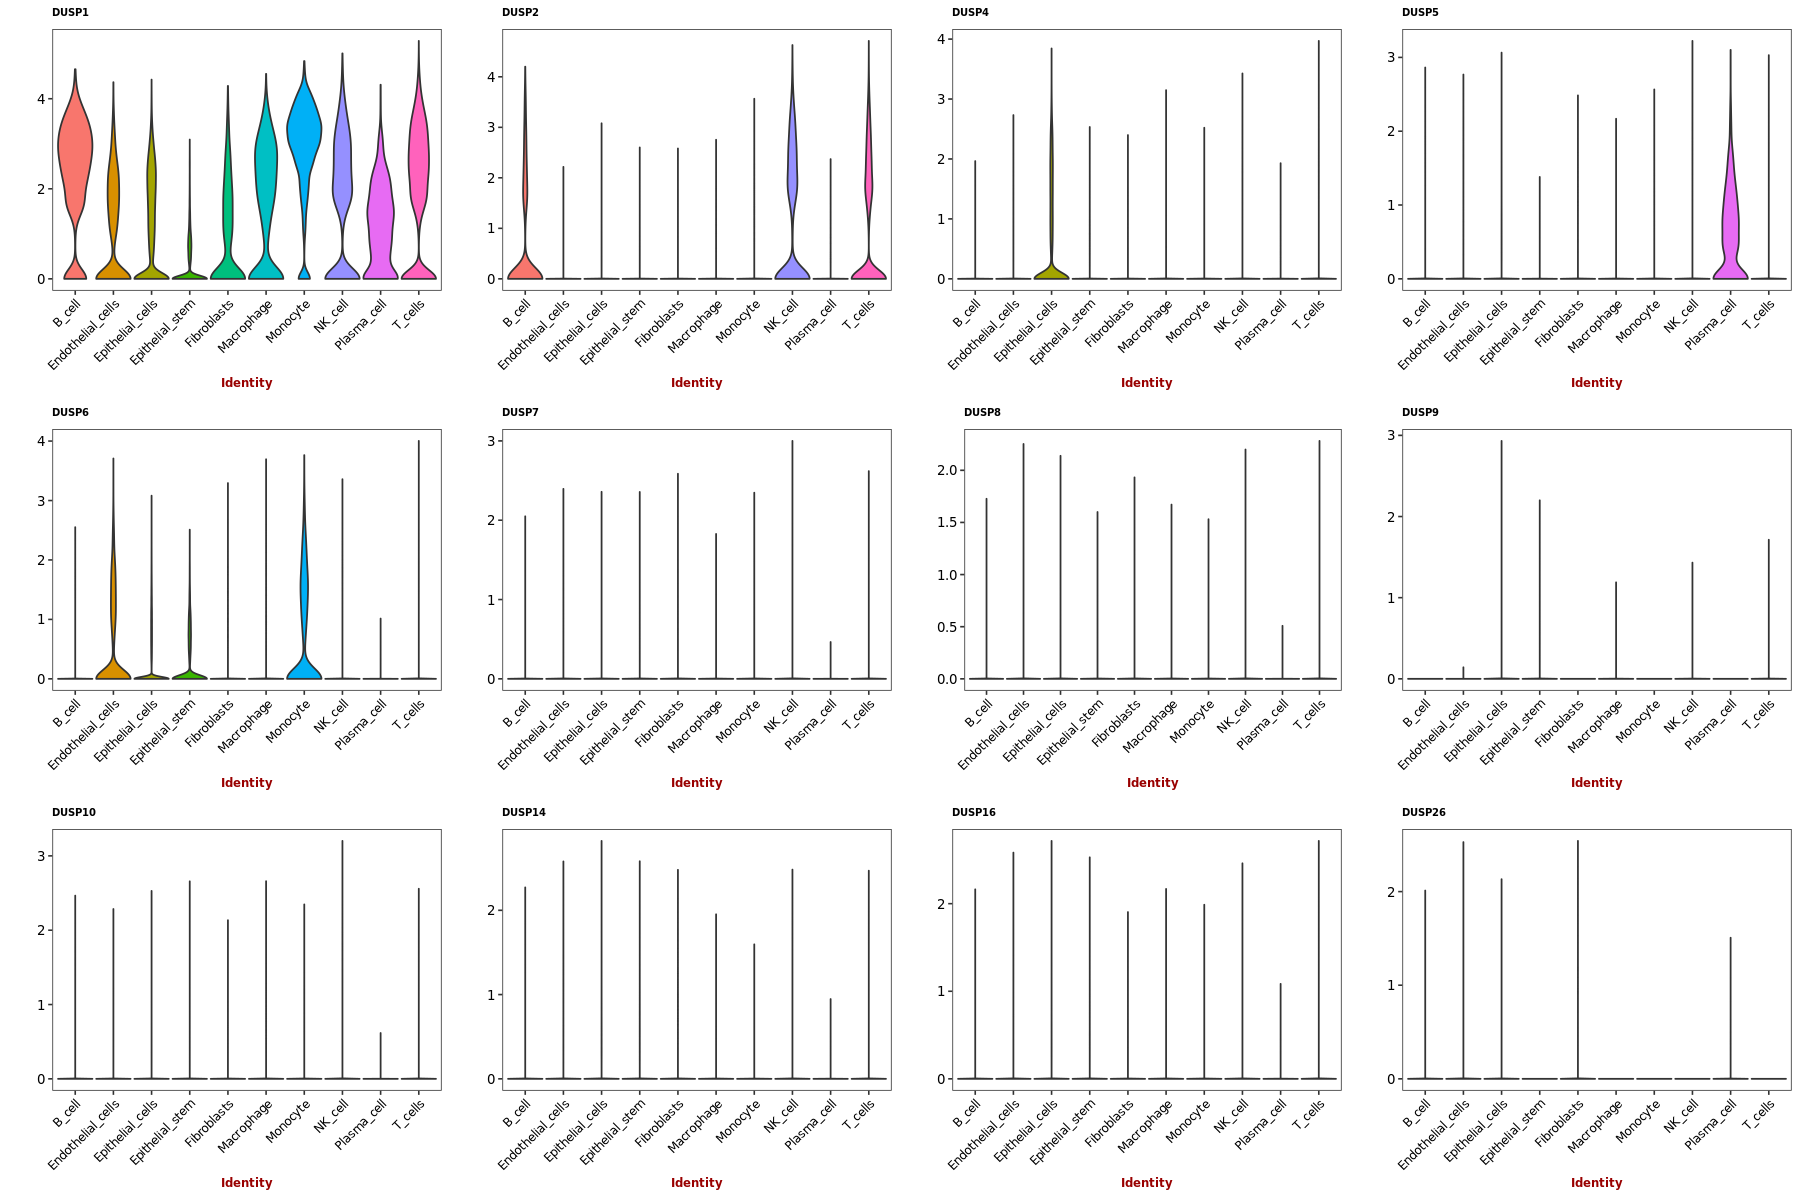

In [181]:
options(repr.plot.width = 15, repr.plot.height = 10)
VlnPlot(SubsetData(cs,subset.name = "labels",accept.value = cell_types,max.cells.per.ident = Inf),size.x.use = 7,group.by = "labels",x.lab.rot = TRUE,remove.legend = TRUE,features.plot = c("DUSP1", "DUSP2", "DUSP4", "DUSP5", "DUSP6", "DUSP7", "DUSP8", "DUSP9", "DUSP10", "DUSP14", "DUSP16" ,"DUSP26"),
        point.size.use = 0,size.title.use = 6)

### checking dropouts

In [3]:
#dropouts
dropouts=c("CCL2","CCNE2","CD24","CD69","FABP7","FCGR3A","GPR160","GZMB","HLA-A","HLA-B","HLA-C","HLA-DRB1","HLA-DRB5","HSPB1","IFITM3","IGLC2","IGLC3","IGLC7","LILRB1","LYZ","MT2A","NAT1","NDC80","NUF2","OBP2B","PABPC1","PTTG1","S100A8","TFF1","TMSB10","TMSB4X","UBE2T","XCL1","XCL2","ZNF571")

In [4]:
sel=fread("final_selection_300_V3_topics.tsv")
gene_stats_annot_red=fread("candidate_gene_stats_red_V3_topics.tsv")

In [8]:
sel_drop=sel[!gene%in%dropouts]

In [6]:
unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))[!unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))%in%unique(unlist(strsplit(sel$type,"\\|")))]

[1] "Epithelial_cells-"

In [12]:
lost_type=unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))[!unique(unlist(strsplit(gene_stats_annot_red$type,"\\|")))%in%unique(unlist(strsplit(sel_drop$type,"\\|")))]
lost_type

[1] "Fibroblasts_t1_GO:0042989" "malignant_t9_GO:0038089"  
[3] "Her2-"                     "Epithelial_cells-"

In [13]:
gene_stats_annot_red[grepl("Fibroblasts_t1_GO:0042989|malignant_t9_GO:0038089|Her2-",type)&!gene%in%dropouts]

gene labels            mean_raw sd_raw  median_raw max_raw min_raw
1 GSN  Endothelial_cells 2.591308 4.71257 1          60      0      
  perc_expr_raw N_expr_raw mean_norm sd_norm median_norm max_norm min_norm
1 0.6251567     1496       1.241517  1.11321 1.336329    4.605269 0       
  perc_expr_norm N_expr_norm type                      method       N_listed
1 0.6251567      1496        Fibroblasts_t1_GO:0042989 topics_fresh 1       
  variability N_expr_all perc_expr_all mean.TPM.Mets cluster_0.7 cluster_0.6
1 0.1564056   19635      0.3194657     55.72746      NA          NA         
  cluster_order priority
1 273           0